### Version 2 - post submission
***

### Environment Information
<table align='left'>
<tr>
    <th>Environment Type</th>
    <th>Anaconda Version</th>
    <th>Anaconda Build Channel</th>
    <th>Python Version</th>
</tr>
<tr>
    <td>Anaconda </td>
    <td>2021.11 </td>
    <td>py39_0 </td>
    <td>3.9.11 </td>
</tr>
</table>

## Links to Kaggle Datasource: 
***

#### _[Transactional Retail Dataset of Electronics Store](https://www.kaggle.com/datasets/muhammadshahrayar/transactional-retail-dataset-of-electronics-store)_

*  _[dirty_data.csv](https://www.kaggle.com/datasets/muhammadshahrayar/transactional-retail-dataset-of-electronics-store?select=dirty_data.csv)_
*  _[missing_data.csv](https://www.kaggle.com/datasets/muhammadshahrayar/transactional-retail-dataset-of-electronics-store?select=missing_data.csv)_
*  _[warehouses.csv](https://www.kaggle.com/datasets/muhammadshahrayar/transactional-retail-dataset-of-electronics-store?select=warehouses.csv)_


# Table of Contents
- [3: Setup](#setup)
- [4: CSV Import and review](#CSVImport)
- [5: Detect and fix errors in df_dirty_data DataFrame](#Fix_df_dirty_data)
    - [Repair 'nearest_warehouse' name](#rename_nearest_warehouse)
    - [Investigate incorrect 'order_total' and 'order_price'](#order_price_total)
    - [Repair 'season' names](#rename_season)
    - [Repair 'customer_lat'itude and longitude](#fix_latitude)
- [6: Detect and fix errors in df_missing_data DataFrame](#Fix_df_missing_data)
    - [Identify and insert missing 'nearest_warehouse' values](#missing_nearest_warehouse)
    - [Identify and insert missing 'order_price' values](#missing_order_price)
    - [Identify and insert missing 'order_total' values](#missing_order_total)
    - [Identify and insert missing 'season' values](#missing_season)
    - [Identify and insert missing 'distance_to_nearest_warehouse' values](#missing_distance_to_nearest_warehouse)
- [7: Append cleaned Dataframes df_dirty_data and df_missing_data](#Appenddf_dirty_datadf_missing_data)
- [8: Create new df_customer_addresses DataFrame and export to CSV](#df_customer_addresses) 
- [9: Create new df_warehouse_addresses DataFrame and export to CSV](#df_warehouse_addresses) 
- [10: Merge df_order_data, df_customer_addresses and df_warehouse_addresses](#merge_df_order_data) 
- [11: Summary Statistics](#summary_statistics) 
- [12: Visualisations](#Visualisations)





<a id='setup'></a>

# Setup

<div class='alert alert-block alert-info'><b></b>installing an importing modules, setting variables and functions </div>

## Install Modules

In [598]:
# modules required
%pip install matplotlib
%pip install pandas
%pip install seaborn
%pip install geopy
%pip install plotly

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Modules
***

In [599]:
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns

import time
from datetime import datetime

from geopy.distance import geodesic
from geopy.geocoders import Nominatim
import plotly.express as px

from IPython.display import display

## Set Variables
***

In [600]:
# set all csv variables
dirty_data = 'dirty_data.csv'
missing_data = 'missing_data.csv'
warehouse_data = 'warehouses.csv'
customer_addresses = 'customer_addresses.csv' 
warehouse_addresses = 'warehouse_addresses.csv'

create_df_customer_addresses = 0 # set to 1 if you wnat section 8 to run:
create_df_warehouse_addresses = 0 # set to 1 if you wnat section 9 to run:

## Functions
***

In [601]:
def get_nearest_warehouse(lat, Long ):
    ''' use coordinates to find the closest warehouse (crow flies) using geodesic API'''
    
    # test values:  get_nearest_warehouse(-37.815105, 144.932843)
    
    # customer coordinates are provided
    coords_customer = lat, Long
    
    # get warehouse latitude and longitide from warehouse table
    coords_Nickolson = df_warehouse_data['lat'].loc[df_warehouse_data.index[0]], df_warehouse_data['lon'].loc[df_warehouse_data.index[0]]
    coords_Thompson = df_warehouse_data['lat'].loc[df_warehouse_data.index[1]], df_warehouse_data['lon'].loc[df_warehouse_data.index[1]]
    coords_Bakers = df_warehouse_data['lat'].loc[df_warehouse_data.index[2]], df_warehouse_data['lon'].loc[df_warehouse_data.index[2]]
    
    # use geodesic to do a km distance comparison
    Nickolson_cust_dist = geodesic(coords_customer, coords_Nickolson).km
    Thompson_cust_dist = geodesic(coords_customer, coords_Thompson).km
    Bakers_cust_dist = geodesic(coords_customer, coords_Bakers).km
    
    val = (Nickolson_cust_dist, Thompson_cust_dist, Bakers_cust_dist)
    
    # get the min value distance value
    min_dist = val.index(min(val))
    
     # convert min_dist to warehouse name and distance in km
    if min_dist == 0:
        warehouse = 'Nickolson'
        distance = Nickolson_cust_dist
        return(warehouse, distance)
    elif min_dist == 1:
        warehouse = 'Thompson'
        distance = Nickolson_cust_dist
        return(warehouse, distance)
    else: 
        warehouse = 'Bakers'
        distance = Nickolson_cust_dist
        
        return str(warehouse), distance        

In [602]:
def get_order_price(order_total, delivery_charges, coupon_discount):
    ''' calculate order_price from order_total, delivery_charges and coupon_discount '''
        # test:  get_order_price(11059.89, 79.89, 10 )
        
    order_price = (order_total - delivery_charges) / (100-coupon_discount) * 100
    return round(order_price, 2) 

In [603]:
def get_order_total(order_price, delivery_charges, coupon_discount):
    ''' calculate order_total from order_price, delivery_charges and coupon_discount'''
    # test values : get_order_total(11059.89, 79.89, 10 )
    
    order_total = order_price - (order_price / 100 * coupon_discount) + delivery_charges
    return round(order_total, 2)


In [604]:
def get_season(date):
    '''calculate season from date'''
    # test values : get_season(datetime(2019, 6, 22))
    
    # Spring = months 9,10,11
    # summer = months 12,1,2
    # Autumn = months 3,4,5
    # Winter = months 6,7,8

    month = date.month

    if month in [9,10,11]:
        season = 'Spring'
    elif month in [12,1,2]:
        season = 'Summer'
    elif month in [3,4,5]:
        season = 'Autumn'
    else:
        season = 'Winter'
    
    return season

In [605]:
def get_geo_address(customer_id, lat, long):
    '''use  Nominatim API to get address data from customer_lat and customer_long'''
    # test values:  get_geo_address('ID6231506320', -37.8117454, 144.9564037)
    
    # create an instance     
    geolocator = Nominatim(user_agent='app')
      
    coordinates =  str(lat) + ' ' + str(long)
    
    #apply the method to get the location
    location = geolocator.reverse(coordinates,timeout=None)
    # return the required address      
    address = location.raw['address']
    road = address.get('road', '')
    suburb = address.get('suburb', '')
    city = address.get('city', '')
    postcode = address.get('postcode', '')
    state = address.get('state', '')
    country = address.get('country', '')
    
    return customer_id, road, suburb, city, postcode, state, country

In [606]:
def convert_to_negative(val):
    '''get the negative of a passed value'''
    # test values:  convert_to_negative(37.8117454)
    
    # simple multiply by -1     
    negative_val = val * (-1)
    
    return negative_val

<a id='CSVImport'></a>

# CSV Import and review
***

<div class='alert alert-block alert-info'><b></b>Create DataFrames<strong>  df_dirty_data</strong>, <strong>df_missing_data</strong>, <strong>df_warehouse_data</strong>, <strong>df_customer_addresses</strong> and <strong>df_warehouse_addresses</strong><br>Imported from relevent CSVs<br>Datatype changes are made on import where possible, some indexes set and columns selected</div>

In [607]:
# read the CSV from the local Jupyter Notebook directory 
# parsing dates on import since dates were objects also change datatype on order_price
df_dirty_data = pd.read_csv(dirty_data, parse_dates=['date'], dtype={'order_price': 'float'}) 
df_missing_data = pd.read_csv(missing_data, parse_dates=['date']) 
df_warehouse_data = pd.read_csv(warehouse_data)
df_customer_addresses = pd.read_csv(customer_addresses, dtype={'postcode': 'int'}, usecols=['customer_id','road','suburb','city','postcode','state','country'],index_col='customer_id') #this csv is created for this assignment in Section 7
df_warehouse_addresses = pd.read_csv(warehouse_addresses, dtype={'postcode': 'int'}, usecols=['warehouse','road','suburb','city','postcode','state','country'], index_col='warehouse')  #this csv is created for this assignment in Section 8

## Data Review
***

### df_dirty_data dataframe review

In [608]:
type(df_dirty_data)

pandas.core.frame.DataFrame

In [609]:
print(df_dirty_data.columns)

Index(['order_id', 'customer_id', 'date', 'nearest_warehouse', 'shopping_cart',
       'order_price', 'delivery_charges', 'customer_lat', 'customer_long',
       'coupon_discount', 'order_total', 'season', 'is_expedited_delivery',
       'distance_to_nearest_warehouse', 'latest_customer_review',
       'is_happy_customer'],
      dtype='object')


In [610]:
# will use display command for better tabular formatting in jupyter Notebook
display(df_dirty_data.head())

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD182494,ID6197211592,2019-06-22,Thompson,"[('Lucent 330S', 1), ('Thunder line', 2), ('iStream', 2), ('pearTV', 1)]",12200.0,79.89,-37.815105,144.932843,10,11059.89,Winter,True,1.2800,perfect phone and trusted seller. phone itself is amazing. i got this phone as shown here on the...,True
1,ORD395518,ID0282825849,2019-12-29,Thompson,"[('Thunder line', 1), ('Universe Note', 2)]",9080.0,62.71,-37.802736,144.951118,0,9142.71,Summer,False,1.1621,"it keeps dropping calls the wifi don't work this is a waste of money this phone is worthless, it...",False
2,ORD494479,ID0579391891,2019-03-02,Nickolson,"[('Thunder line', 1), ('pearTV', 2)]",10670.0,65.87,-37.821302,144.957581,10,9668.87,Autumn,False,1.0949,five stars this is a great cheap phone.,True
3,ORD019224,ID4544561904,2019-01-12,Nickolson,"[('Universe Note', 1), ('Alcon 10', 2), ('Olivia x460', 1), ('iAssist Line', 1)]",24800.0,57.61,-37.811416,144.973073,15,21137.61,Summer,False,0.8571,charger did not fit the charger didn't fit.,False
4,ORD104032,ID6231506320,2019-11-28,Nickolson,"[('Universe Note', 1), ('Olivia x460', 1), ('iStream', 1), ('Toshika 750', 1)]",9145.0,75.54,37.823859,144.969892,25,6934.29,Spring,False,0.5867,four stars good,True


In [611]:
# will use display command for better tabular formatting in jupyter Notebook
display(df_dirty_data.describe())

,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,distance_to_nearest_warehouse
count,500.000000,500.000000,500.000000,500.000000,500.000000,5.000000e+02,500.000000
mean,25522.216000,76.658200,-35.835234,144.969494,10.890000,3.920967e+04,2.204224
std,86333.729169,14.481465,12.045393,0.022720,8.649134,2.741940e+05,8.812416
min,585.000000,46.350000,-37.827123,144.924967,0.000000,6.392900e+02,0.107800
25%,7050.000000,65.982500,-37.818222,144.953488,5.000000,6.454735e+03,0.751425
50%,12807.500000,76.310000,-37.812165,144.965357,10.000000,1.129396e+04,1.030100
75%,20360.000000,82.555000,-37.805364,144.983985,15.000000,1.811919e+04,1.408625
max,947691.000000,114.040000,37.826339,145.019837,25.000000,5.688270e+06,94.973400


In [612]:
print(df_dirty_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       500 non-null    object        
 1   customer_id                    500 non-null    object        
 2   date                           500 non-null    datetime64[ns]
 3   nearest_warehouse              500 non-null    object        
 4   shopping_cart                  500 non-null    object        
 5   order_price                    500 non-null    float64       
 6   delivery_charges               500 non-null    float64       
 7   customer_lat                   500 non-null    float64       
 8   customer_long                  500 non-null    float64       
 9   coupon_discount                500 non-null    int64         
 10  order_total                    500 non-null    float64       
 11  season             

In [613]:
print(df_dirty_data.shape)

(500, 16)


In [614]:
# no NaN found
print(df_dirty_data.isnull().any())

order_id                         False
customer_id                      False
date                             False
nearest_warehouse                False
shopping_cart                    False
order_price                      False
delivery_charges                 False
customer_lat                     False
customer_long                    False
coupon_discount                  False
order_total                      False
season                           False
is_expedited_delivery            False
distance_to_nearest_warehouse    False
latest_customer_review           False
is_happy_customer                False
dtype: bool


In [615]:
missing_values_count = df_dirty_data.isnull().sum()
print(missing_values_count[0:16])

order_id                         0
customer_id                      0
date                             0
nearest_warehouse                0
shopping_cart                    0
order_price                      0
delivery_charges                 0
customer_lat                     0
customer_long                    0
coupon_discount                  0
order_total                      0
season                           0
is_expedited_delivery            0
distance_to_nearest_warehouse    0
latest_customer_review           0
is_happy_customer                0
dtype: int64


### df_missing_data dataframe review

In [616]:
type(df_missing_data)

pandas.core.frame.DataFrame

In [617]:
print(df_missing_data.columns)

Index(['order_id', 'customer_id', 'date', 'nearest_warehouse', 'shopping_cart',
       'order_price', 'delivery_charges', 'customer_lat', 'customer_long',
       'coupon_discount', 'order_total', 'season', 'is_expedited_delivery',
       'distance_to_nearest_warehouse', 'latest_customer_review',
       'is_happy_customer'],
      dtype='object')


In [618]:
display(df_missing_data.head())

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD382112,ID0289597187,2019-03-06,Thompson,"[('pearTV', 1), ('Candle Inferno', 2)]",7170.0,61.72,-37.811782,144.951972,15,6156.22,Autumn,True,0.4425,"to many adds in ui it has adds, sends info to manufacture,",False
1,ORD378488,ID1668523020,2019-05-05,Thompson,"[('Thunder line', 1), ('Lucent 330S', 2), ('Alcon 10', 1)]",13590.0,65.20,-37.808236,144.942181,10,12296.20,Autumn,False,0.6547,s10e haven't had this phone but a short time but i have fallen in love lol,True
2,ORD279446,ID0370751503,2019-03-24,Bakers,"[('Candle Inferno', 2), ('Universe Note', 1)]",4310.0,78.75,-37.812941,144.985883,15,3742.25,NaN,True,0.8852,"best bang for your buck! great overall android phone, no damages during shipping and after a mon...",True
3,ORD277196,ID0634774947,2019-01-12,Thompson,"[('pearTV', 1), ('Thunder line', 1), ('Olivia x460', 2)]",10940.0,92.59,-37.811748,144.938192,25,8297.59,Summer,True,0.7875,good it was a gift for my niece. it to her in jamaica.,True
4,ORD116193,ID3313210924,2019-09-02,Nickolson,"[('pearTV', 2), ('Universe Note', 2), ('Thunder line', 1)]",21700.0,95.62,-37.818393,144.967034,5,20710.62,Spring,True,0.2225,"excellent product excellent product, was received as described, was delivered at the correct time.",True


In [619]:
display(df_missing_data.describe())

,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,distance_to_nearest_warehouse
count,490.000000,500.000000,490.000000,490.000000,500.000000,490.000000,490.000000
mean,13217.867347,77.683380,-37.812597,144.966114,11.190000,11939.841020,1.077335
std,7552.951453,14.566667,0.007593,0.021054,8.734213,7032.605471,0.509914
min,580.000000,46.200000,-37.828216,144.921217,0.000000,568.640000,0.054900
25%,7140.000000,66.975000,-37.818755,144.951541,5.000000,6486.542500,0.723625
50%,12180.000000,77.275000,-37.813053,144.963409,10.000000,10756.615000,1.043350
75%,18327.500000,85.217500,-37.806714,144.980157,15.000000,16315.555000,1.389525
max,37300.000000,110.990000,-37.788265,145.017015,25.000000,37362.470000,3.138800


In [620]:
print(df_missing_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       500 non-null    object        
 1   customer_id                    500 non-null    object        
 2   date                           500 non-null    datetime64[ns]
 3   nearest_warehouse              490 non-null    object        
 4   shopping_cart                  500 non-null    object        
 5   order_price                    490 non-null    float64       
 6   delivery_charges               500 non-null    float64       
 7   customer_lat                   490 non-null    float64       
 8   customer_long                  490 non-null    float64       
 9   coupon_discount                500 non-null    int64         
 10  order_total                    490 non-null    float64       
 11  season             

In [621]:
print(df_missing_data.shape)

(500, 16)


In [622]:
print(df_missing_data.isnull().any())

order_id                         False
customer_id                      False
date                             False
nearest_warehouse                 True
shopping_cart                    False
order_price                       True
delivery_charges                 False
customer_lat                      True
customer_long                     True
coupon_discount                  False
order_total                       True
season                            True
is_expedited_delivery            False
distance_to_nearest_warehouse     True
latest_customer_review           False
is_happy_customer                 True
dtype: bool


In [623]:
print(df_missing_data.isnull().sum())

order_id                          0
customer_id                       0
date                              0
nearest_warehouse                10
shopping_cart                     0
order_price                      10
delivery_charges                  0
customer_lat                     10
customer_long                    10
coupon_discount                   0
order_total                      10
season                           10
is_expedited_delivery             0
distance_to_nearest_warehouse    10
latest_customer_review            0
is_happy_customer                10
dtype: int64


### df_warehouse_data dataframe review

In [624]:
type(df_warehouse_data)

pandas.core.frame.DataFrame

In [625]:
print(df_warehouse_data.columns)

Index(['names', 'lat', 'lon'], dtype='object')


In [626]:
type(df_warehouse_data)

pandas.core.frame.DataFrame

In [627]:
display(df_warehouse_data.head())

,names,lat,lon
0,Nickolson,-37.818595,144.969551
1,Thompson,-37.812673,144.947069
2,Bakers,-37.809996,144.995232


In [628]:
display(df_warehouse_data.describe())

,lat,lon
count,3.000000,3.000000
mean,-37.813755,144.970617
std,0.004400,0.024099
min,-37.818595,144.947069
25%,-37.815634,144.958310
50%,-37.812673,144.969551
75%,-37.811335,144.982392
max,-37.809996,144.995232


In [629]:
print(df_warehouse_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   names   3 non-null      object 
 1   lat     3 non-null      float64
 2   lon     3 non-null      float64
dtypes: float64(2), object(1)
memory usage: 200.0+ bytes
None


In [630]:
print(df_warehouse_data.shape)

(3, 3)


In [631]:
print(df_warehouse_data.isnull().any())

names    False
lat      False
lon      False
dtype: bool


In [632]:
print(df_warehouse_data.isnull().sum())

names    0
lat      0
lon      0
dtype: int64


### df_customer_addresses dataframe review

[This DataFrame is created in Section 8](#df_customer_addresses)

In [633]:
type(df_customer_addresses)

pandas.core.frame.DataFrame

In [634]:
print(df_customer_addresses.columns)

Index(['road', 'suburb', 'city', 'postcode', 'state', 'country'], dtype='object')


In [635]:
type(df_customer_addresses)

pandas.core.frame.DataFrame

In [636]:
display(df_customer_addresses.head())

,road,suburb,city,postcode,state,country
customer_id,,,,,,
ID6197211592,CityLink,Docklands,Melbourne,3008,Victoria,Australia
ID0282825849,Queensberry Street,North Melbourne,Melbourne,3051,Victoria,Australia
ID0579391891,Rebecca Walk,Melbourne,Melbourne,3000,Victoria,Australia
ID4544561904,Bourke Street,East Melbourne,Melbourne,3000,Victoria,Australia
ID6231506320,Musicians lane,Southbank,Melbourne,3006,Victoria,Australia


In [637]:
display(df_customer_addresses.describe())

,postcode
count,970.000000
mean,3036.628866
std,69.897023
min,3000.000000
25%,3000.000000
50%,3008.000000
75%,3053.000000
max,3746.000000


In [638]:
print(df_customer_addresses.info())

<class 'pandas.core.frame.DataFrame'>
Index: 970 entries, ID6197211592 to ID0634783923
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   road      970 non-null    object
 1   suburb    970 non-null    object
 2   city      970 non-null    object
 3   postcode  970 non-null    int64 
 4   state     970 non-null    object
 5   country   970 non-null    object
dtypes: int64(1), object(5)
memory usage: 53.0+ KB
None


In [639]:
print(df_customer_addresses.shape)

(970, 6)


In [640]:
print(df_customer_addresses.isnull().any())

road        False
suburb      False
city        False
postcode    False
state       False
country     False
dtype: bool


In [641]:
print(df_customer_addresses.isnull().sum())

road        0
suburb      0
city        0
postcode    0
state       0
country     0
dtype: int64


### df_warehouse_addresses dataframe review

[This DataFrame is created in Section 9](#df_warehouse_addresses)

In [642]:
type(df_warehouse_addresses)

pandas.core.frame.DataFrame

In [643]:
print(df_warehouse_addresses.columns)

Index(['road', 'suburb', 'city', 'postcode', 'state', 'country'], dtype='object')


In [644]:
type(df_warehouse_addresses)

pandas.core.frame.DataFrame

In [645]:
display(df_warehouse_addresses.head())

,road,suburb,city,postcode,state,country
warehouse,,,,,,
Nickolson,Princes Walk,Melbourne,Melbourne,3000,Victoria,Australia
Thompson,Dudley Street,Docklands,Melbourne,3008,Victoria,Australia
Bakers,Victoria Street,Abbotsford,Melbourne,3067,Victoria,Australia


In [646]:
display(df_warehouse_addresses.describe())

,postcode
count,3.000000
mean,3025.000000
std,36.592349
min,3000.000000
25%,3004.000000
50%,3008.000000
75%,3037.500000
max,3067.000000


In [647]:
print(df_warehouse_addresses.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, Nickolson to Bakers
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   road      3 non-null      object
 1   suburb    3 non-null      object
 2   city      3 non-null      object
 3   postcode  3 non-null      int64 
 4   state     3 non-null      object
 5   country   3 non-null      object
dtypes: int64(1), object(5)
memory usage: 168.0+ bytes
None


In [648]:
print(df_warehouse_addresses.shape)

(3, 6)


In [649]:
print(df_warehouse_addresses.isnull().any())

road        False
suburb      False
city        False
postcode    False
state       False
country     False
dtype: bool


In [650]:
print(df_warehouse_addresses.isnull().sum())

road        0
suburb      0
city        0
postcode    0
state       0
country     0
dtype: int64


## Create Indexes

In [651]:
# check for orderid uniqueness in df_dirty_data
duplicate_dirty_data = df_dirty_data[df_dirty_data.duplicated(['order_id'])]
print(duplicate_dirty_data)

Empty DataFrame
Columns: [order_id, customer_id, date, nearest_warehouse, shopping_cart, order_price, delivery_charges, customer_lat, customer_long, coupon_discount, order_total, season, is_expedited_delivery, distance_to_nearest_warehouse, latest_customer_review, is_happy_customer]
Index: []


In [652]:
# check for orderid uniqueness in df_missing_data 
duplicate_missing_data = df_missing_data[df_missing_data.duplicated(['order_id'])]
print(duplicate_missing_data)

Empty DataFrame
Columns: [order_id, customer_id, date, nearest_warehouse, shopping_cart, order_price, delivery_charges, customer_lat, customer_long, coupon_discount, order_total, season, is_expedited_delivery, distance_to_nearest_warehouse, latest_customer_review, is_happy_customer]
Index: []


In [653]:
# create an order_id index on df_dirty_data
df_dirty_data.set_index('order_id',inplace=True)

In [654]:
# create an order_id index on df_missing_data
df_missing_data.set_index('order_id',inplace=True)

In [655]:
print(df_dirty_data.index)

Index(['ORD182494', 'ORD395518', 'ORD494479', 'ORD019224', 'ORD104032',
       'ORD146760', 'ORD337984', 'ORD072312', 'ORD377837', 'ORD462194',
       ...
       'ORD182549', 'ORD435271', 'ORD082002', 'ORD034351', 'ORD379700',
       'ORD475510', 'ORD086060', 'ORD079320', 'ORD026546', 'ORD085447'],
      dtype='object', name='order_id', length=500)


In [656]:
print(df_missing_data.index)

Index(['ORD382112', 'ORD378488', 'ORD279446', 'ORD277196', 'ORD116193',
       'ORD005004', 'ORD296379', 'ORD447851', 'ORD078449', 'ORD018258',
       ...
       'ORD273851', 'ORD329425', 'ORD277938', 'ORD297371', 'ORD218866',
       'ORD289820', 'ORD425999', 'ORD252675', 'ORD215989', 'ORD414852'],
      dtype='object', name='order_id', length=500)


<a id='Fix_df_dirty_data'></a>

# Detect and fix errors in df_dirty_data DataFrame
***

<div class='alert alert-block alert-info'><b></b>Fixing anomolous data issues with <strong>df_dirty_data</strong> DataFrame</div>

In [657]:
# show missing values - none found
print(df_dirty_data.isnull().sum())

customer_id                      0
date                             0
nearest_warehouse                0
shopping_cart                    0
order_price                      0
delivery_charges                 0
customer_lat                     0
customer_long                    0
coupon_discount                  0
order_total                      0
season                           0
is_expedited_delivery            0
distance_to_nearest_warehouse    0
latest_customer_review           0
is_happy_customer                0
dtype: int64


In [658]:
print(df_dirty_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, ORD182494 to ORD085447
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    500 non-null    object        
 1   date                           500 non-null    datetime64[ns]
 2   nearest_warehouse              500 non-null    object        
 3   shopping_cart                  500 non-null    object        
 4   order_price                    500 non-null    float64       
 5   delivery_charges               500 non-null    float64       
 6   customer_lat                   500 non-null    float64       
 7   customer_long                  500 non-null    float64       
 8   coupon_discount                500 non-null    int64         
 9   order_total                    500 non-null    float64       
 10  season                         500 non-null    object        
 11  is_expedit

In [659]:
df_dirty_data['customer_id'].sort_values().unique()

array(['ID0026051948', 'ID0030385486', 'ID0030385740', 'ID0030945778',
       'ID0030946633', 'ID0036822341', 'ID0036825302', 'ID0052450483',
       'ID0052510917', 'ID0052600120', 'ID0052600161', 'ID0054552169',
       'ID0054558290', 'ID0060088412', 'ID0060096961', 'ID0076459536',
       'ID0103121662', 'ID0103299651', 'ID0107172471', 'ID0122752291',
       'ID0126934535', 'ID0127674021', 'ID0129952519', 'ID0130015098',
       'ID0130040956', 'ID0131221774', 'ID0131247270', 'ID0131247323',
       'ID0144730304', 'ID0145261554', 'ID0153681683', 'ID0202736642',
       'ID0202767927', 'ID0207085738', 'ID0207093524', 'ID0207093574',
       'ID0207093578', 'ID0214092261', 'ID0227316137', 'ID0233270890',
       'ID0233314845', 'ID0243097196', 'ID0245493801', 'ID0245531235',
       'ID0245533066', 'ID0246439398', 'ID0247010166', 'ID0247018750',
       'ID0247024616', 'ID0247417082', 'ID0247417091', 'ID0247417667',
       'ID0247417828', 'ID0248129431', 'ID0248266256', 'ID0248746737',
      

In [660]:
df_dirty_data['customer_id'].apply(len).unique()

array([12])

In [661]:
type(df_dirty_data['customer_id'].sort_values().unique())

numpy.ndarray

In [662]:
display(df_dirty_data.head())

,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
order_id,,,,,,,,,,,,,,,
ORD182494,ID6197211592,2019-06-22,Thompson,"[('Lucent 330S', 1), ('Thunder line', 2), ('iStream', 2), ('pearTV', 1)]",12200.0,79.89,-37.815105,144.932843,10,11059.89,Winter,True,1.2800,perfect phone and trusted seller. phone itself is amazing. i got this phone as shown here on the...,True
ORD395518,ID0282825849,2019-12-29,Thompson,"[('Thunder line', 1), ('Universe Note', 2)]",9080.0,62.71,-37.802736,144.951118,0,9142.71,Summer,False,1.1621,"it keeps dropping calls the wifi don't work this is a waste of money this phone is worthless, it...",False
ORD494479,ID0579391891,2019-03-02,Nickolson,"[('Thunder line', 1), ('pearTV', 2)]",10670.0,65.87,-37.821302,144.957581,10,9668.87,Autumn,False,1.0949,five stars this is a great cheap phone.,True
ORD019224,ID4544561904,2019-01-12,Nickolson,"[('Universe Note', 1), ('Alcon 10', 2), ('Olivia x460', 1), ('iAssist Line', 1)]",24800.0,57.61,-37.811416,144.973073,15,21137.61,Summer,False,0.8571,charger did not fit the charger didn't fit.,False
ORD104032,ID6231506320,2019-11-28,Nickolson,"[('Universe Note', 1), ('Olivia x460', 1), ('iStream', 1), ('Toshika 750', 1)]",9145.0,75.54,37.823859,144.969892,25,6934.29,Spring,False,0.5867,four stars good,True


In [663]:
columns = df_dirty_data.columns
print(len(columns))

15


<a id='rename_nearest_warehouse'></a>

### Repair 'nearest_warehouse name

In [664]:
# getting the unique values for 'nearest_warehouse' 
nearest_warehouse = df_dirty_data['nearest_warehouse'].sort_values().unique()
print(nearest_warehouse)

['Bakers' 'Nickolson' 'Thompson' 'nickolson' 'thompson']


In [665]:
# capatilise the first character 
df_dirty_data['nearest_warehouse'] = df_dirty_data['nearest_warehouse'].str.title()

<a id='rename_season'></a>

### Repair 'season' names

In [666]:
# getting the unique values for 'season'
season = df_dirty_data['season'].sort_values().unique()
print(season)

['Autumn' 'Spring' 'Summer' 'Winter' 'autumn' 'spring' 'summer' 'winter']


In [667]:
# capatilise the first character 
df_dirty_data['season'] = df_dirty_data['season'].str.title()

<a id='order_price_total'></a>

### Repair incorrect 'order_total' and 'order_price'

In [668]:
price = df_dirty_data['order_price']

print('Q2 quantile of order_price : ', np.quantile(price, .50))
print('Q1 quantile of order_price : ', np.quantile(price, .25))
print('Q3 quantile of order_price : ', np.quantile(price, .75))
print('100th quantile of order_price : ', np.quantile(price, .1))

Q2 quantile of order_price :  12807.5
Q1 quantile of order_price :  7050.0
Q3 quantile of order_price :  20360.0
100th quantile of order_price :  4002.000000000002


In [669]:
total = df_dirty_data['order_total']

print('Q2 quantile of order_total : ', np.quantile(total, .50))
print('Q1 quantile of order_total : ', np.quantile(total, .25))
print('Q3 quantile of order_total : ', np.quantile(total, .75))
print('100th quantile of order_total : ', np.quantile(total, .1))

Q2 quantile of order_total :  11293.96
Q1 quantile of order_total :  6454.735
Q3 quantile of order_total :  18119.1875
100th quantile of order_total :  3747.313000000001


### visually comparing 'shopping_cart'  'order_price'  'delivery_charges'  'coupon_discount'  'order_total' 

In [670]:
# sorted by 'order_total','order_price'
df_dirty_data[['shopping_cart','order_price','delivery_charges','coupon_discount','order_total']].sort_values(ascending = False, by=['order_total','order_price']).head(10)

,shopping_cart,order_price,delivery_charges,coupon_discount,order_total
order_id,,,,,
ORD039111,"[('Thunder line', 1), ('Toshika 750', 2)]",10820.0,64.03,0,5688269.60
ORD139508,"[('Toshika 750', 1), ('Candle Inferno', 1), ('Alcon 10', 1), ('Olivia x460', 2)]",16150.0,62.70,5,969651.79
ORD451441,"[('iStream', 1), ('Toshika 750', 2)]",8790.0,85.53,5,967408.88
ORD124395,"[('Alcon 10', 1), ('Universe Note', 1), ('pearTV', 1), ('iStream', 2)]",19010.0,94.75,0,926057.25
ORD015029,"[('Olivia x460', 1), ('Lucent 330S', 1)]",2455.0,77.02,5,909463.94
ORD057375,"[('Thunder line', 1), ('Alcon 10', 1), ('Candle Inferno', 1), ('Universe Note', 2)]",18460.0,93.52,25,665085.66
ORD244594,"[('pearTV', 2), ('Universe Note', 2), ('Thunder line', 1), ('Candle Inferno', 1)]",22130.0,108.92,25,649193.76
ORD450897,"[('Olivia x460', 2), ('pearTV', 2), ('Lucent 330S', 2)]",17530.0,79.05,0,648477.60
ORD481832,"[('Universe Note', 2), ('Candle Inferno', 2), ('pearTV', 1)]",14070.0,73.33,15,620502.30


In [671]:
# sorted by 'order_price','order_total'
df_dirty_data[['shopping_cart','order_price','delivery_charges','coupon_discount','order_total']].sort_values(ascending = False, by=['order_price','order_total']).head(10)

,shopping_cart,order_price,delivery_charges,coupon_discount,order_total
order_id,,,,,
ORD116440,"[('Lucent 330S', 1), ('iAssist Line', 1), ('Candle Inferno', 1), ('pearTV', 1)]",947691.0,90.82,10,9266.32
ORD420200,"[('Alcon 10', 1), ('Olivia x460', 1), ('pearTV', 2)]",865916.0,92.90,15,19468.65
ORD453668,"[('Candle Inferno', 1), ('Toshika 750', 1), ('Lucent 330S', 1), ('Alcon 10', 2)]",672832.0,62.82,25,17972.82
ORD122655,"[('Universe Note', 2), ('Thunder line', 1), ('Candle Inferno', 2), ('Toshika 750', 2)]",655164.0,81.70,10,16803.70
ORD057456,"[('iAssist Line', 2), ('iStream', 1), ('Alcon 10', 2)]",653959.0,66.18,5,21441.18
ORD339649,"[('Alcon 10', 1), ('Thunder line', 2), ('Universe Note', 1), ('Lucent 330S', 2)]",597240.0,79.91,5,18338.91
ORD496181,"[('iAssist Line', 1), ('Alcon 10', 1), ('Olivia x460', 1), ('Candle Inferno', 1)]",461736.0,87.31,25,9709.81
ORD249776,"[('Candle Inferno', 2), ('Lucent 330S', 2), ('pearTV', 2)]",454996.0,79.28,15,13628.28
ORD475510,"[('Alcon 10', 2), ('iAssist Line', 2)]",386776.0,59.70,10,20174.70


In [672]:
# sorted by 'order_price','shopping_cart' perhaps anomolies are from items purchased 
df_dirty_data[['shopping_cart','order_price','delivery_charges','coupon_discount','order_total']].sort_values(ascending = False, by=['order_price','shopping_cart']).head(10)

,shopping_cart,order_price,delivery_charges,coupon_discount,order_total
order_id,,,,,
ORD116440,"[('Lucent 330S', 1), ('iAssist Line', 1), ('Candle Inferno', 1), ('pearTV', 1)]",947691.0,90.82,10,9266.32
ORD420200,"[('Alcon 10', 1), ('Olivia x460', 1), ('pearTV', 2)]",865916.0,92.90,15,19468.65
ORD453668,"[('Candle Inferno', 1), ('Toshika 750', 1), ('Lucent 330S', 1), ('Alcon 10', 2)]",672832.0,62.82,25,17972.82
ORD122655,"[('Universe Note', 2), ('Thunder line', 1), ('Candle Inferno', 2), ('Toshika 750', 2)]",655164.0,81.70,10,16803.70
ORD057456,"[('iAssist Line', 2), ('iStream', 1), ('Alcon 10', 2)]",653959.0,66.18,5,21441.18
ORD339649,"[('Alcon 10', 1), ('Thunder line', 2), ('Universe Note', 1), ('Lucent 330S', 2)]",597240.0,79.91,5,18338.91
ORD496181,"[('iAssist Line', 1), ('Alcon 10', 1), ('Olivia x460', 1), ('Candle Inferno', 1)]",461736.0,87.31,25,9709.81
ORD249776,"[('Candle Inferno', 2), ('Lucent 330S', 2), ('pearTV', 2)]",454996.0,79.28,15,13628.28
ORD475510,"[('Alcon 10', 2), ('iAssist Line', 2)]",386776.0,59.70,10,20174.70


In [673]:
pd.set_option('display.max_colwidth', 100)
df_dirty_data[['shopping_cart','order_price','delivery_charges','coupon_discount','order_total']].sort_values(ascending = True, by=['order_price']).head()

,shopping_cart,order_price,delivery_charges,coupon_discount,order_total
order_id,,,,,
ORD165713,"[('iStream', 2), ('Candle Inferno', 1)]",585.0,91.79,25,639.29
ORD010677,"[('iStream', 2), ('Candle Inferno', 1)]",730.0,108.58,10,765.58
ORD262556,"[('iStream', 1), ('Candle Inferno', 2)]",1010.0,56.50,15,915.00
ORD072308,"[('iStream', 1), ('Candle Inferno', 2)]",1010.0,62.30,0,1072.30
ORD210087,"[('iStream', 1), ('Candle Inferno', 2)]",1010.0,103.41,15,961.91


In [674]:
pd.set_option('max_colwidth', 100)
df_shopping_cart = df_dirty_data[['shopping_cart','order_price']]

# df_shopping_cart_filter = df_shopping_cart[lambda row : row['shopping_cart'].str.contains('Thunder line.*Lucent 330S', regex=True)]
df_shopping_cart_filter = df_shopping_cart[lambda row : row['shopping_cart'].str.contains('Thunder line.*Lucent 330S|Lucent 330S.*Thunder line', regex=True)].head()

df_shopping_cart_filter.sort_values('shopping_cart')
# unique items 'Thunder line', 'Lucent 330S', 'Alcon 10', 'Universe Note', 'Olivia x460', 'Candle Inferno', 'iAssist Line', 'iStream', 'Toshika 750', 'pearTV'

,shopping_cart,order_price
order_id,,
ORD036056,"[('Alcon 10', 1), ('Olivia x460', 2), ('Lucent 330S', 1), ('Thunder line', 1)]",14810.0
ORD178590,"[('Candle Inferno', 1), ('Toshika 750', 2), ('Thunder line', 1), ('Lucent 330S', 2)]",13710.0
ORD182494,"[('Lucent 330S', 1), ('Thunder line', 2), ('iStream', 2), ('pearTV', 1)]",12200.0
ORD026682,"[('iStream', 1), ('Thunder line', 2), ('Candle Inferno', 2), ('Lucent 330S', 2)]",7830.0
ORD103199,"[('iStream', 2), ('Thunder line', 2), ('Lucent 330S', 1)]",5890.0


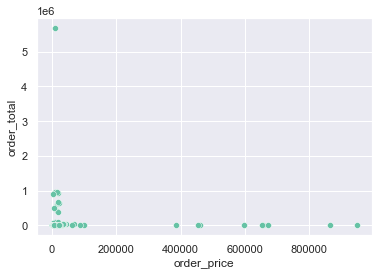

In [675]:
# if we look at order_price versus order_total there are some outliers 
sns.scatterplot(data=df_dirty_data,y='order_total', x='order_price');

In [676]:
# Minimum and maximum order_price versus order_total 
print('Minimum order_price ' + str(df_dirty_data['order_price'].min()));
print('Minimum order_total ' + str(df_dirty_data['order_total'].min()));
print('Maximum order_price ' + str(df_dirty_data['order_price'].max()));
print('Maximum order_total ' + str(df_dirty_data['order_total'].max()));

Minimum order_price 585.0
Minimum order_total 639.29
Maximum order_price 947691.0
Maximum order_total 5688269.6


In [677]:
df_dirty_data.head()

,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
order_id,,,,,,,,,,,,,,,
ORD182494,ID6197211592,2019-06-22,Thompson,"[('Lucent 330S', 1), ('Thunder line', 2), ('iStream', 2), ('pearTV', 1)]",12200.0,79.89,-37.815105,144.932843,10,11059.89,Winter,True,1.2800,perfect phone and trusted seller. phone itself is amazing. i got this phone as shown here on the...,True
ORD395518,ID0282825849,2019-12-29,Thompson,"[('Thunder line', 1), ('Universe Note', 2)]",9080.0,62.71,-37.802736,144.951118,0,9142.71,Summer,False,1.1621,"it keeps dropping calls the wifi don't work this is a waste of money this phone is worthless, it...",False
ORD494479,ID0579391891,2019-03-02,Nickolson,"[('Thunder line', 1), ('pearTV', 2)]",10670.0,65.87,-37.821302,144.957581,10,9668.87,Autumn,False,1.0949,five stars this is a great cheap phone.,True
ORD019224,ID4544561904,2019-01-12,Nickolson,"[('Universe Note', 1), ('Alcon 10', 2), ('Olivia x460', 1), ('iAssist Line', 1)]",24800.0,57.61,-37.811416,144.973073,15,21137.61,Summer,False,0.8571,charger did not fit the charger didn't fit.,False
ORD104032,ID6231506320,2019-11-28,Nickolson,"[('Universe Note', 1), ('Olivia x460', 1), ('iStream', 1), ('Toshika 750', 1)]",9145.0,75.54,37.823859,144.969892,25,6934.29,Spring,False,0.5867,four stars good,True


#### calculating the actual order_total that dont add up from 'order_price' 'delivery_charges' 'coupon_discount', listing those order_ids 

In [678]:
# lets find where (order_price - coupon_discount + delivery_charges != order_total) dont add up 
# we can use function get_order_total to get order_id where they dont match 
# add incorrect rows to new dataframe df_incorrect_order_total

df_incorrect_order_total = pd.DataFrame()

for i, row in df_dirty_data.iterrows():
    if df_dirty_data.at[i, 'order_total'] != get_order_total(df_dirty_data.at[i,'order_price'],df_dirty_data.at[i,'delivery_charges'],df_dirty_data.at[i,'coupon_discount']):
        df_incorrect_order_total = pd.concat([df_incorrect_order_total, pd.DataFrame.from_records([{'order_id':i, 'order_price':df_dirty_data.at[i,'order_price'],
                                                                                                    'delivery_charges':df_dirty_data.at[i,'delivery_charges'],
                                                                                                    'coupon_discount':df_dirty_data.at[i,'coupon_discount'],
                                                                                                    'order_total':df_dirty_data.at[i,'order_total']}])],ignore_index=True)

In [679]:
display(df_incorrect_order_total.sort_values('order_total', ascending=False))

,order_id,order_price,delivery_charges,coupon_discount,order_total
21,ORD039111,10820.0,64.03,0,5688269.60
15,ORD139508,16150.0,62.70,5,969651.79
10,ORD451441,8790.0,85.53,5,967408.88
1,ORD124395,19010.0,94.75,0,926057.25
31,ORD015029,2455.0,77.02,5,909463.94
34,ORD057375,18460.0,93.52,25,665085.66
14,ORD244594,22130.0,108.92,25,649193.76
12,ORD450897,17530.0,79.05,0,648477.60
3,ORD481832,14070.0,73.33,15,620502.30
17,ORD131352,7760.0,76.34,5,507327.39


#### calculating the actual order_price that dont add up from 'order_total' 'delivery_charges' 'coupon_discount', listing those order_ids

In [680]:
# lets find where (order_total - delivery_charges / coupon_discount != order_price) dont add up
# we can use function get_order_price to get order_id where they dont match
# add incorrect rows dataframe df_incorrect_order_price

df_incorrect_order_price = pd.DataFrame()

for i, row in df_dirty_data.iterrows():
    if df_dirty_data.at[i,'order_price'] != get_order_price(df_dirty_data.at[i,'order_total'],df_dirty_data.at[i,'delivery_charges'],df_dirty_data.at[i,'coupon_discount']):
        df_incorrect_order_price = pd.concat([df_incorrect_order_price, pd.DataFrame.from_records([{'order_id':i,                                               
                'order_price':df_dirty_data.at[i,'order_price'],                                 
                'delivery_charges':df_dirty_data.at[i,'delivery_charges'],
                'coupon_discount':df_dirty_data.at[i,'coupon_discount'], 
                'order_total':df_dirty_data.at[i,'order_total']}])],ignore_index=True)

In [681]:
display(df_incorrect_order_price.sort_values('order_total', ascending=False))

,order_id,order_price,delivery_charges,coupon_discount,order_total
21,ORD039111,10820.0,64.03,0,5688269.60
15,ORD139508,16150.0,62.70,5,969651.79
10,ORD451441,8790.0,85.53,5,967408.88
1,ORD124395,19010.0,94.75,0,926057.25
31,ORD015029,2455.0,77.02,5,909463.94
34,ORD057375,18460.0,93.52,25,665085.66
14,ORD244594,22130.0,108.92,25,649193.76
12,ORD450897,17530.0,79.05,0,648477.60
3,ORD481832,14070.0,73.33,15,620502.30
17,ORD131352,7760.0,76.34,5,507327.39


In [682]:
# we can conclude that 40 orders have incorrect calculations for either order_price or order_total,they will be removed 
# it makes sense that df_incorrect_order_price and df_incorrect_order_total contain the same rows 
df_incorrect_order_id = df_incorrect_order_price['order_id'] = df_incorrect_order_total['order_id']
print(df_incorrect_order_id.count())

40


In [683]:
# list of order_id's that are incorrect
list_incorrect_order_id = df_incorrect_order_id.tolist()
print(list_incorrect_order_id)

['ORD072312', 'ORD124395', 'ORD383725', 'ORD481832', 'ORD386513', 'ORD158007', 'ORD122655', 'ORD016018', 'ORD059126', 'ORD127141', 'ORD451441', 'ORD420200', 'ORD450897', 'ORD113085', 'ORD244594', 'ORD139508', 'ORD063814', 'ORD131352', 'ORD339649', 'ORD253502', 'ORD379975', 'ORD039111', 'ORD346356', 'ORD165713', 'ORD028403', 'ORD496181', 'ORD116440', 'ORD381638', 'ORD349135', 'ORD130025', 'ORD428011', 'ORD015029', 'ORD057456', 'ORD216875', 'ORD057375', 'ORD317652', 'ORD249776', 'ORD453668', 'ORD449772', 'ORD475510']


### remove list_incorrect_order_id from df_dirty_data 

In [684]:
# use the list created above 'list_incorrect_order_id' to remove orders that have incorrect order_price and order_total's 
print(df_dirty_data.drop(df_dirty_data[df_dirty_data.index.isin(list_incorrect_order_id)].index,inplace=True))

None


In [685]:
df_dirty_data.head()

,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
order_id,,,,,,,,,,,,,,,
ORD182494,ID6197211592,2019-06-22,Thompson,"[('Lucent 330S', 1), ('Thunder line', 2), ('iStream', 2), ('pearTV', 1)]",12200.0,79.89,-37.815105,144.932843,10,11059.89,Winter,True,1.2800,perfect phone and trusted seller. phone itself is amazing. i got this phone as shown here on the...,True
ORD395518,ID0282825849,2019-12-29,Thompson,"[('Thunder line', 1), ('Universe Note', 2)]",9080.0,62.71,-37.802736,144.951118,0,9142.71,Summer,False,1.1621,"it keeps dropping calls the wifi don't work this is a waste of money this phone is worthless, it...",False
ORD494479,ID0579391891,2019-03-02,Nickolson,"[('Thunder line', 1), ('pearTV', 2)]",10670.0,65.87,-37.821302,144.957581,10,9668.87,Autumn,False,1.0949,five stars this is a great cheap phone.,True
ORD019224,ID4544561904,2019-01-12,Nickolson,"[('Universe Note', 1), ('Alcon 10', 2), ('Olivia x460', 1), ('iAssist Line', 1)]",24800.0,57.61,-37.811416,144.973073,15,21137.61,Summer,False,0.8571,charger did not fit the charger didn't fit.,False
ORD104032,ID6231506320,2019-11-28,Nickolson,"[('Universe Note', 1), ('Olivia x460', 1), ('iStream', 1), ('Toshika 750', 1)]",9145.0,75.54,37.823859,144.969892,25,6934.29,Spring,False,0.5867,four stars good,True


<a id='fix_latitude'></a>

### Repair 'customer_lat'itude and longitude

#### Check Latitude and Longitude in df_dirty_data

In [686]:
max_long = df_dirty_data['customer_long'].max();
min_long = df_dirty_data['customer_long'].min()
max_lat = df_dirty_data['customer_lat'].max();
min_lat = df_dirty_data['customer_lat'].min()
print('max_longitude:',max_long)
print('max_latitude:',max_lat)
print('min_longitude:',min_long)
print('min_latitude:',min_lat)

max_longitude: 145.0198375
max_latitude: 37.8263393
min_longitude: 144.9249672
min_latitude: -37.8271233


In [687]:
# getting index where 'customer_lat' is positive
positive_customer_lat_indexto_update = df_dirty_data[df_dirty_data['customer_lat'] > 0 ].index
print(positive_customer_lat_indexto_update)

Index(['ORD104032', 'ORD146760', 'ORD074913', 'ORD236167', 'ORD010677',
       'ORD256016', 'ORD103709', 'ORD184906', 'ORD165627', 'ORD389541',
       'ORD007904', 'ORD194707', 'ORD026546'],
      dtype='object', name='order_id')


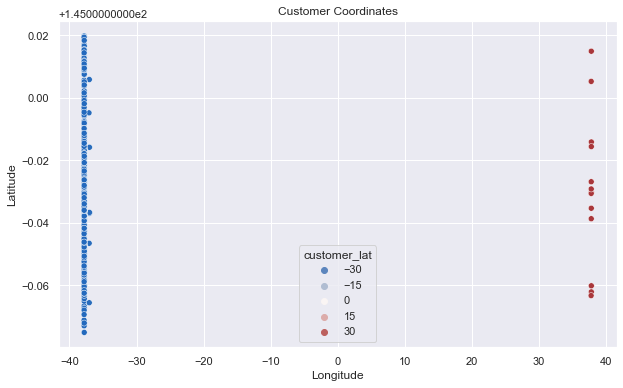

In [688]:
#  using a scatterplot to visualise discrepancies in Latitude and Longitude in the df_dirty_data DataFrame
#  the scatterplot shows there are some positive latitude values, we'll map these to see where they are
plt.figure(figsize = (10,6))
sns.set_theme(style='darkgrid');

ax = sns.scatterplot(x='customer_lat', y='customer_long', data=df_dirty_data, hue='customer_lat', palette = 'vlag')
plt.title('Customer Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()  

In [689]:
# map shows coordinates are in the Melbourne area and off the Japanese coast, unless Captain Nemo ordered some supplies im assuming this to be incorrect
# zoom on the map for closer inspection
# needs WebGL enabled in browser
fig = px.scatter_mapbox(df_dirty_data, lat='customer_lat', lon='customer_long',color_discrete_sequence=['DarkRed'], zoom=2, height=600, center=dict(lat=-4, lon=160), size='customer_long')
fig.update_layout(mapbox_style='open-street-map',margin={'r':500,'t':0,'l':0,'b':0})
fig.show()

In [690]:
# df_dirty_data.describe shows the max value
display(df_dirty_data.describe()[['customer_lat']])
# min and percentiles are in the -37 decimal range with the exception of the max 37, I suggest these latitudes should be negative, will change and observe the difference 
# if making the values negative re-positions to Melbourne it is probably ok

,customer_lat
count,460.000000
mean,-35.663518
std,12.544571
min,-37.827123
25%,-37.818284
50%,-37.812503
75%,-37.805420
max,37.826339


In [691]:
# list all rows where 'customer_lat' is positive
positive_customer_lat_to_update = df_dirty_data[df_dirty_data['customer_lat'] > 0 ]
display(positive_customer_lat_to_update[['customer_lat']])

,customer_lat
order_id,
ORD104032,37.823859
ORD146760,37.820245
ORD074913,37.823093
ORD236167,37.804518
ORD010677,37.826339
ORD256016,37.791485
ORD103709,37.808119
ORD184906,37.810246
ORD165627,37.815897


In [692]:
# getting index where 'customer_lat' is positive
positive_customer_lat_indexto_update = df_dirty_data[df_dirty_data['customer_lat'] > 0 ].index
print(positive_customer_lat_indexto_update)

Index(['ORD104032', 'ORD146760', 'ORD074913', 'ORD236167', 'ORD010677',
       'ORD256016', 'ORD103709', 'ORD184906', 'ORD165627', 'ORD389541',
       'ORD007904', 'ORD194707', 'ORD026546'],
      dtype='object', name='order_id')


In [693]:
# updating  values for 'customer_lat'
for i, row in positive_customer_lat_to_update.iterrows():
    df_dirty_data.at[i,'customer_lat'] = convert_to_negative(df_dirty_data.at[i,'customer_lat'])

In [694]:
# list all rows where 'customer_lat' is positive : all fixed
positive_customer_lat_to_update = df_dirty_data[df_dirty_data['customer_lat'] > 0 ]
display(positive_customer_lat_to_update)

,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
order_id,,,,,,,,,,,,,,,


In [695]:
#check the indexes for the updated 'customer_lat' --  all done
display(df_dirty_data[['customer_lat']].loc[positive_customer_lat_indexto_update])

,customer_lat
order_id,
ORD104032,-37.823859
ORD146760,-37.820245
ORD074913,-37.823093
ORD236167,-37.804518
ORD010677,-37.826339
ORD256016,-37.791485
ORD103709,-37.808119
ORD184906,-37.810246
ORD165627,-37.815897


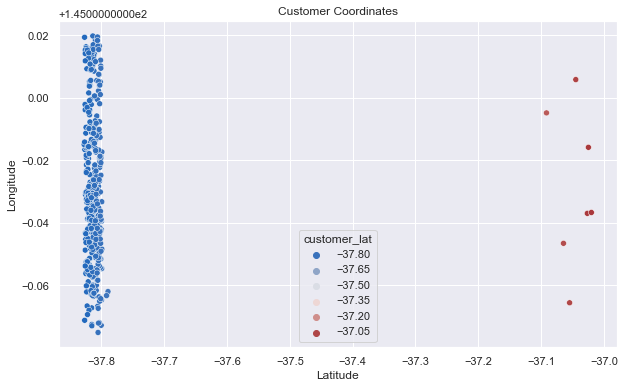

In [696]:
# using a scatterplot to visualise updated in Latitude and Longitude in the df_dirty_data DataFrame
# all values are negative and all within -37
plt.figure(figsize = (10,6))
sns.set_theme(style='darkgrid');

sns.scatterplot(x='customer_lat', y='customer_long', data=df_dirty_data, hue='customer_lat', palette = 'vlag')
plt.title('Customer Coordinates')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

In [697]:
# check the updated coordinates are in the Melbourne area, all seem to be good, all located downtown Melbourne and north of Melbourne
# zoom on the map for closer inspection
# needs WebGL enabled in browser
fig = px.scatter_mapbox(df_dirty_data, lat='customer_lat', lon='customer_long',color_discrete_sequence=['DarkRed'],center=dict(lat=-37.5, lon=145), zoom=7)
fig.update_layout(mapbox_style='open-street-map',margin={'r':500,'t':0,'l':0,'b':0})
fig.show()

#### Check Latitude and Longitude in df_missing_data

In [698]:
max_long = df_missing_data['customer_long'].max();
min_long = df_missing_data['customer_long'].min()
max_lat = df_missing_data['customer_lat'].max();
min_lat = df_missing_data['customer_lat'].min()
print('max_longitude:',max_long)
print('max_latitude:',max_lat)
print('min_longitude:',min_long)
print('min_latitude:',min_lat)

max_longitude: 145.0170153
max_latitude: -37.7882653
min_longitude: 144.9212169
min_latitude: -37.8282162


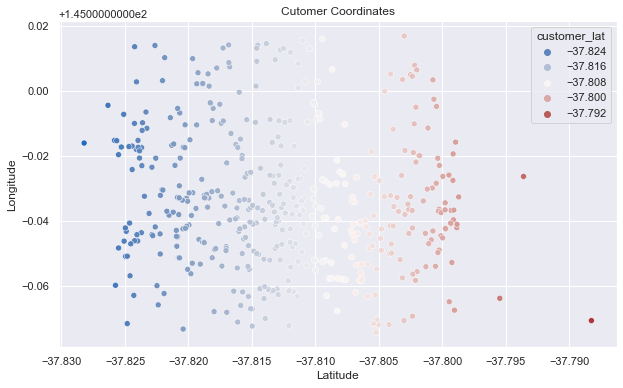

In [699]:
# here we can see the scatterplot contains an even distribution for negative latitude values in the df_missing_data DataFrame
# all -37
plt.figure(figsize = (10,6))
sns.set_theme(style='darkgrid');

sns.scatterplot(x='customer_lat', y='customer_long',data=df_missing_data,  hue='customer_lat', palette = 'vlag')
plt.title('Cutomer Coordinates',)
# Set x-axis label
plt.xlabel('Latitude')
# Set y-axis label
plt.ylabel('Longitude')
plt.show()

In [700]:
# map shows all coordinates are in the Melbourne area in df_missing_data nothing seems out of order
# zoom on the map for closer inspection
fig = px.scatter_mapbox(df_missing_data, lat='customer_lat', lon='customer_long',color_discrete_sequence=['DarkRed'], zoom=11)
fig.update_layout(mapbox_style='open-street-map',margin={'r':500,'t':0,'l':0,'b':0})
fig.show()

<a id='Fix_df_missing_data'></a>

# Detect and Fix missing values in df_missing_data DataFrame
***

<div class='alert alert-block alert-info'><b></b>Fixing missing data issues with <strong>df_missing_data</strong> DataFrame</div>

In [701]:
# show missing values
print(df_missing_data.isnull().sum())

customer_id                       0
date                              0
nearest_warehouse                10
shopping_cart                     0
order_price                      10
delivery_charges                  0
customer_lat                     10
customer_long                    10
coupon_discount                   0
order_total                      10
season                           10
is_expedited_delivery             0
distance_to_nearest_warehouse    10
latest_customer_review            0
is_happy_customer                10
dtype: int64


<a id='missing_nearest_warehouse'></a>

### Identify and insert missing 'nearest_warehouse' values

In [702]:
# getting rows for the missing values for 'nearest_warehouse'
nearest_warehouse_to_update = df_missing_data[df_missing_data['nearest_warehouse'].isnull()]

display(nearest_warehouse_to_update[['nearest_warehouse']])

,nearest_warehouse
order_id,
ORD447851,NaN
ORD256447,NaN
ORD159597,NaN
ORD474381,NaN
ORD372144,NaN
ORD052805,NaN
ORD222346,NaN
ORD229269,NaN
ORD433678,NaN


In [703]:
# getting index for the the missing values for 'nearest_warehouse'
nearest_warehouse_indexto_update = df_missing_data[df_missing_data['nearest_warehouse'].isnull()].index
print(nearest_warehouse_indexto_update)

Index(['ORD447851', 'ORD256447', 'ORD159597', 'ORD474381', 'ORD372144',
       'ORD052805', 'ORD222346', 'ORD229269', 'ORD433678', 'ORD075737'],
      dtype='object', name='order_id')


In [704]:
# updating missing values for 'nearest_warehouse'
for i, row in nearest_warehouse_to_update.iterrows():
    df_missing_data.at[i,'nearest_warehouse'] = get_nearest_warehouse(df_missing_data.at[i,'customer_lat'],df_missing_data.at[i,'customer_long'])[0]

In [705]:
# no more missing values for 'nearest_warehouse'
print(df_missing_data[df_missing_data['nearest_warehouse'].isnull()])

Empty DataFrame
Columns: [customer_id, date, nearest_warehouse, shopping_cart, order_price, delivery_charges, customer_lat, customer_long, coupon_discount, order_total, season, is_expedited_delivery, distance_to_nearest_warehouse, latest_customer_review, is_happy_customer]
Index: []


In [706]:
#check the indexes for the update 'nearest_warehouse' --  all done
display(df_missing_data[['nearest_warehouse']].loc[nearest_warehouse_indexto_update])

,nearest_warehouse
order_id,
ORD447851,Nickolson
ORD256447,Bakers
ORD159597,Bakers
ORD474381,Nickolson
ORD372144,Thompson
ORD052805,Nickolson
ORD222346,Bakers
ORD229269,Thompson
ORD433678,Nickolson


<a id='missing_order_price'></a>

### Identify and insert missing 'order_price' values

In [707]:
# getting rows for the missing values for 'order_price'
order_price_to_update = df_missing_data[df_missing_data['order_price'].isnull()]

display(order_price_to_update[['order_price']])

,order_price
order_id,
ORD309901,NaN
ORD375694,NaN
ORD276249,NaN
ORD052574,NaN
ORD413785,NaN
ORD077311,NaN
ORD428743,NaN
ORD403951,NaN
ORD271310,NaN


In [708]:
# getting index for the the missing values for 'order_price'
order_price_indexto_update = df_missing_data[df_missing_data['order_price'].isnull()].index
print(order_price_indexto_update)

Index(['ORD309901', 'ORD375694', 'ORD276249', 'ORD052574', 'ORD413785',
       'ORD077311', 'ORD428743', 'ORD403951', 'ORD271310', 'ORD042295'],
      dtype='object', name='order_id')


In [709]:
# updating missing values for 'order_price'
for i, row in order_price_to_update.iterrows():
    df_missing_data.at[i,'order_price'] = get_order_price(df_missing_data.at[i,'order_total'],df_missing_data.at[i,'delivery_charges'],df_missing_data.at[i,'coupon_discount'])

In [710]:
# no more missing values for 'order_price'
print(df_missing_data[df_missing_data['order_price'].isnull()])

Empty DataFrame
Columns: [customer_id, date, nearest_warehouse, shopping_cart, order_price, delivery_charges, customer_lat, customer_long, coupon_discount, order_total, season, is_expedited_delivery, distance_to_nearest_warehouse, latest_customer_review, is_happy_customer]
Index: []


In [711]:
#check the indexes for the update 'order_price' --  all done
display(df_missing_data[['order_price']].loc[order_price_indexto_update])

,order_price
order_id,
ORD309901,13625.0
ORD375694,31385.0
ORD276249,21210.0
ORD052574,16710.0
ORD413785,17250.0
ORD077311,4680.0
ORD428743,34660.0
ORD403951,14630.0
ORD271310,4685.0


<a id='missing_order_total'></a>

### Identify and insert missing 'order_price' values

In [712]:
# getting rows for the missing values for 'order_total'
order_total_to_update = df_missing_data[df_missing_data['order_total'].isnull()]

display(order_total_to_update[['order_total']])

,order_total
order_id,
ORD177154,NaN
ORD467869,NaN
ORD386228,NaN
ORD323368,NaN
ORD481503,NaN
ORD355999,NaN
ORD246570,NaN
ORD109486,NaN
ORD354308,NaN


In [713]:
# getting index for the the missing values for 'order_total'
order_total_indexto_update = df_missing_data[df_missing_data['order_total'].isnull()].index
print(order_total_indexto_update)

Index(['ORD177154', 'ORD467869', 'ORD386228', 'ORD323368', 'ORD481503',
       'ORD355999', 'ORD246570', 'ORD109486', 'ORD354308', 'ORD489113'],
      dtype='object', name='order_id')


In [714]:
# updating missing values for 'order_total'
for i, row in order_total_to_update.iterrows():
    df_missing_data.at[i,'order_total'] = get_order_total(df_missing_data.at[i,'order_price'],df_missing_data.at[i,'delivery_charges'],df_missing_data.at[i,'coupon_discount'])

In [715]:
# no more missing values for 'order_total'
print(df_missing_data[df_missing_data['order_total'].isnull()])

Empty DataFrame
Columns: [customer_id, date, nearest_warehouse, shopping_cart, order_price, delivery_charges, customer_lat, customer_long, coupon_discount, order_total, season, is_expedited_delivery, distance_to_nearest_warehouse, latest_customer_review, is_happy_customer]
Index: []


In [716]:
#check the indexes for the update 'order_total' --  all done
display(df_missing_data[['order_total']].loc[order_total_indexto_update])

,order_total
order_id,
ORD177154,9551.62
ORD467869,13353.84
ORD386228,13323.29
ORD323368,11414.07
ORD481503,9243.29
ORD355999,14713.63
ORD246570,10917.36
ORD109486,4752.05
ORD354308,4301.60


<a id='missing_season'></a>

### Identify and insert missing 'season' values

In [717]:
# getting rows for the missing values for 'season'
season_to_update = df_missing_data[df_missing_data['season'].isnull()]

display(season_to_update[['season']])

,season
order_id,
ORD279446,NaN
ORD083901,NaN
ORD250242,NaN
ORD078069,NaN
ORD016552,NaN
ORD429692,NaN
ORD434639,NaN
ORD032506,NaN
ORD027479,NaN


In [718]:
# getting index for the the missing values for 'order_total'
season_indexto_update = df_missing_data[df_missing_data['season'].isnull()].index
print(season_indexto_update)

Index(['ORD279446', 'ORD083901', 'ORD250242', 'ORD078069', 'ORD016552',
       'ORD429692', 'ORD434639', 'ORD032506', 'ORD027479', 'ORD437147'],
      dtype='object', name='order_id')


In [719]:
# getting the unique values for 'season'
seasons = df_missing_data['season'].sort_values().unique()
print(seasons)

['Autumn' 'Spring' 'Summer' 'Winter' nan]


In [720]:
# get the season months from the grouping of the orders..obviously Southern hemisphere - a random lat long shows its Melbourne, Australia area
season_months = df_missing_data.groupby([pd.Grouper(key='date', axis=0, freq='M'),'season']).sum().filter(items=['date','season'])
display(season_months)
# summer = months 12,1,2
# Autumn = months 3,4,5
# Winter = months 6,7,8
# Spring = months 9,10,11

,
date,season
2019-01-31,Summer
2019-02-28,Summer
2019-03-31,Autumn
2019-04-30,Autumn
2019-05-31,Autumn
2019-06-30,Winter
2019-07-31,Winter
2019-08-31,Winter
2019-09-30,Spring


In [721]:
# updating missing values for 'season'
for i, row in df_missing_data.iterrows():
    df_missing_data.at[i,'season'] = get_season(df_missing_data.at[i,'date'])

In [722]:
# no more missing values for 'season'
print(df_missing_data[df_missing_data['season'].isnull()])

Empty DataFrame
Columns: [customer_id, date, nearest_warehouse, shopping_cart, order_price, delivery_charges, customer_lat, customer_long, coupon_discount, order_total, season, is_expedited_delivery, distance_to_nearest_warehouse, latest_customer_review, is_happy_customer]
Index: []


In [723]:
#check the indexes for the update 'season' --  all done
display(df_missing_data[['season']].loc[order_total_indexto_update])

,season
order_id,
ORD177154,Winter
ORD467869,Spring
ORD386228,Spring
ORD323368,Spring
ORD481503,Summer
ORD355999,Summer
ORD246570,Spring
ORD109486,Autumn
ORD354308,Summer


<a id='missing_distance_to_nearest_warehouse'></a>

### Identify and insert missing 'distance_to_nearest_warehouse' values

In [724]:
# getting rows for the missing values for 'distance_to_nearest_warehouse'
distance_to_nearest_warehouse_to_update = df_missing_data[df_missing_data['distance_to_nearest_warehouse'].isnull()]

display(distance_to_nearest_warehouse_to_update[['distance_to_nearest_warehouse']])

,distance_to_nearest_warehouse
order_id,
ORD265586,NaN
ORD224296,NaN
ORD247311,NaN
ORD465260,NaN
ORD160120,NaN
ORD174660,NaN
ORD048679,NaN
ORD392649,NaN
ORD137128,NaN


In [725]:
# getting index for the the missing values for 'distance_to_nearest_warehouse'
distance_to_nearest_warehouse_indexto_update = df_missing_data[df_missing_data['distance_to_nearest_warehouse'].isnull()].index
print(distance_to_nearest_warehouse_indexto_update)

Index(['ORD265586', 'ORD224296', 'ORD247311', 'ORD465260', 'ORD160120',
       'ORD174660', 'ORD048679', 'ORD392649', 'ORD137128', 'ORD132417'],
      dtype='object', name='order_id')


In [726]:
# updating missing values for 'distance_to_nearest_warehouse'
for i, row in distance_to_nearest_warehouse_to_update.iterrows():
    df_missing_data.at[i,'distance_to_nearest_warehouse'] = get_nearest_warehouse(df_missing_data.at[i,'customer_lat'],df_missing_data.at[i,'customer_long'])[1]

In [727]:
# no more missing values for 'distance_to_nearest_warehouse'
print(df_missing_data[df_missing_data['distance_to_nearest_warehouse'].isnull()])

Empty DataFrame
Columns: [customer_id, date, nearest_warehouse, shopping_cart, order_price, delivery_charges, customer_lat, customer_long, coupon_discount, order_total, season, is_expedited_delivery, distance_to_nearest_warehouse, latest_customer_review, is_happy_customer]
Index: []


In [728]:
#check the indexes for the update 'season' --  all done
display(df_missing_data[['distance_to_nearest_warehouse']].loc[order_total_indexto_update])

,distance_to_nearest_warehouse
order_id,
ORD177154,1.1751
ORD467869,1.5693
ORD386228,1.5685
ORD323368,1.5645
ORD481503,1.5146
ORD355999,0.8535
ORD246570,0.5281
ORD109486,1.6033
ORD354308,0.7148


<a id='Appenddf_dirty_datadf_missing_data'></a>

# Append cleaned Dataframes df_dirty_data and df_missing_data
***

<div class='alert alert-block alert-info'><b></b>Work is complete on correcting issues with <strong>df_missing_data</strong> and <strong>df_dirty_data</strong> they are appended here to create <strong>df_order_data</strong><br> NaN are filtered from 'customer_lat', 'customer_long' and 'is_happy_customer'</div>

In [729]:
df_missing_data.shape

(500, 15)

In [730]:
df_missing_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, ORD382112 to ORD414852
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    500 non-null    object        
 1   date                           500 non-null    datetime64[ns]
 2   nearest_warehouse              500 non-null    object        
 3   shopping_cart                  500 non-null    object        
 4   order_price                    500 non-null    float64       
 5   delivery_charges               500 non-null    float64       
 6   customer_lat                   490 non-null    float64       
 7   customer_long                  490 non-null    float64       
 8   coupon_discount                500 non-null    int64         
 9   order_total                    500 non-null    float64       
 10  season                         500 non-null    object        
 11  is_expedit

In [731]:
df_missing_data.index

Index(['ORD382112', 'ORD378488', 'ORD279446', 'ORD277196', 'ORD116193',
       'ORD005004', 'ORD296379', 'ORD447851', 'ORD078449', 'ORD018258',
       ...
       'ORD273851', 'ORD329425', 'ORD277938', 'ORD297371', 'ORD218866',
       'ORD289820', 'ORD425999', 'ORD252675', 'ORD215989', 'ORD414852'],
      dtype='object', name='order_id', length=500)

In [732]:
df_missing_data.isnull().sum()

customer_id                       0
date                              0
nearest_warehouse                 0
shopping_cart                     0
order_price                       0
delivery_charges                  0
customer_lat                     10
customer_long                    10
coupon_discount                   0
order_total                       0
season                            0
is_expedited_delivery             0
distance_to_nearest_warehouse     0
latest_customer_review            0
is_happy_customer                10
dtype: int64

In [733]:
df_dirty_data.shape

(460, 15)

In [734]:
df_dirty_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460 entries, ORD182494 to ORD085447
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    460 non-null    object        
 1   date                           460 non-null    datetime64[ns]
 2   nearest_warehouse              460 non-null    object        
 3   shopping_cart                  460 non-null    object        
 4   order_price                    460 non-null    float64       
 5   delivery_charges               460 non-null    float64       
 6   customer_lat                   460 non-null    float64       
 7   customer_long                  460 non-null    float64       
 8   coupon_discount                460 non-null    int64         
 9   order_total                    460 non-null    float64       
 10  season                         460 non-null    object        
 11  is_expedit

In [735]:
df_dirty_data.index

Index(['ORD182494', 'ORD395518', 'ORD494479', 'ORD019224', 'ORD104032',
       'ORD146760', 'ORD337984', 'ORD377837', 'ORD462194', 'ORD034800',
       ...
       'ORD161955', 'ORD182549', 'ORD435271', 'ORD082002', 'ORD034351',
       'ORD379700', 'ORD086060', 'ORD079320', 'ORD026546', 'ORD085447'],
      dtype='object', name='order_id', length=460)

In [736]:
df_dirty_data.isnull().sum()

customer_id                      0
date                             0
nearest_warehouse                0
shopping_cart                    0
order_price                      0
delivery_charges                 0
customer_lat                     0
customer_long                    0
coupon_discount                  0
order_total                      0
season                           0
is_expedited_delivery            0
distance_to_nearest_warehouse    0
latest_customer_review           0
is_happy_customer                0
dtype: int64

In [737]:
# remove NaN for 'customer_lat', 'customer_long' and 'is_happy_customer' from df_missing_data
df_missing_data_NoNa = df_missing_data[(df_missing_data['customer_lat'].notna()) & (df_missing_data['customer_long'].notna()) & (df_missing_data['is_happy_customer'].notna())]
display(df_missing_data_NoNa)

,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
order_id,,,,,,,,,,,,,,,
ORD382112,ID0289597187,2019-03-06,Thompson,"[('pearTV', 1), ('Candle Inferno', 2)]",7170.0,61.72,-37.811782,144.951972,15,6156.22,Autumn,True,0.4425,"to many adds in ui it has adds, sends info to manufacture,",False
ORD378488,ID1668523020,2019-05-05,Thompson,"[('Thunder line', 1), ('Lucent 330S', 2), ('Alcon 10', 1)]",13590.0,65.20,-37.808236,144.942181,10,12296.20,Autumn,False,0.6547,s10e haven't had this phone but a short time but i have fallen in love lol,True
ORD279446,ID0370751503,2019-03-24,Bakers,"[('Candle Inferno', 2), ('Universe Note', 1)]",4310.0,78.75,-37.812941,144.985883,15,3742.25,Autumn,True,0.8852,"best bang for your buck! great overall android phone, no damages during shipping and after a mon...",True
ORD277196,ID0634774947,2019-01-12,Thompson,"[('pearTV', 1), ('Thunder line', 1), ('Olivia x460', 2)]",10940.0,92.59,-37.811748,144.938192,25,8297.59,Summer,True,0.7875,good it was a gift for my niece. it to her in jamaica.,True
ORD116193,ID3313210924,2019-09-02,Nickolson,"[('pearTV', 2), ('Universe Note', 2), ('Thunder line', 1)]",21700.0,95.62,-37.818393,144.967034,5,20710.62,Spring,True,0.2225,"excellent product excellent product, was received as described, was delivered at the correct time.",True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ORD289820,ID0711745634,2019-06-24,Thompson,"[('Toshika 750', 1), ('Lucent 330S', 2), ('Candle Inferno', 1), ('Universe Note', 1)]",10660.0,46.20,-37.815309,144.945919,15,9107.20,Winter,False,0.3104,batería dañada hola. la batería se dañó. donde puedo solicitar su reemplazo o reparación?,False
ORD425999,ID3208518274,2019-02-12,Nickolson,"[('pearTV', 2), ('Olivia x460', 1), ('iAssist Line', 1), ('Universe Note', 2)]",22970.0,83.03,-37.802503,144.967428,15,19607.53,Summer,False,1.8010,great phone for the money. the price was right. it works well and the battery easily lasts 2 days.,True
ORD252675,ID0589449505,2019-09-14,Nickolson,"[('Alcon 10', 2), ('Thunder line', 2), ('Universe Note', 1), ('Toshika 750', 2)]",34350.0,78.57,-37.809446,144.972736,15,29276.07,Spring,False,1.0563,"four stars very good olivia universe s5 , i would rate 4 stars",True


In [738]:
# create a new dataframe from df_dirty_data_NoNa and df_missing_data_NoNa 
# df_order_data = df_dirty_data_NoNa.append(df_missing_data_NoNa, ignore_index=False)
df_order_data  = pd.concat([df_dirty_data, df_missing_data_NoNa], verify_integrity=True)

# df_order_data = pd.concat([df_missing_data_NoNa, df_dirty_data_NoNa ], ignore_index=False)

In [739]:
df_order_data = df_order_data.reset_index()

In [740]:
display(df_order_data)

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD182494,ID6197211592,2019-06-22,Thompson,"[('Lucent 330S', 1), ('Thunder line', 2), ('iStream', 2), ('pearTV', 1)]",12200.0,79.89,-37.815105,144.932843,10,11059.89,Winter,True,1.2800,perfect phone and trusted seller. phone itself is amazing. i got this phone as shown here on the...,True
1,ORD395518,ID0282825849,2019-12-29,Thompson,"[('Thunder line', 1), ('Universe Note', 2)]",9080.0,62.71,-37.802736,144.951118,0,9142.71,Summer,False,1.1621,"it keeps dropping calls the wifi don't work this is a waste of money this phone is worthless, it...",False
2,ORD494479,ID0579391891,2019-03-02,Nickolson,"[('Thunder line', 1), ('pearTV', 2)]",10670.0,65.87,-37.821302,144.957581,10,9668.87,Autumn,False,1.0949,five stars this is a great cheap phone.,True
3,ORD019224,ID4544561904,2019-01-12,Nickolson,"[('Universe Note', 1), ('Alcon 10', 2), ('Olivia x460', 1), ('iAssist Line', 1)]",24800.0,57.61,-37.811416,144.973073,15,21137.61,Summer,False,0.8571,charger did not fit the charger didn't fit.,False
4,ORD104032,ID6231506320,2019-11-28,Nickolson,"[('Universe Note', 1), ('Olivia x460', 1), ('iStream', 1), ('Toshika 750', 1)]",9145.0,75.54,-37.823859,144.969892,25,6934.29,Spring,False,0.5867,four stars good,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,ORD289820,ID0711745634,2019-06-24,Thompson,"[('Toshika 750', 1), ('Lucent 330S', 2), ('Candle Inferno', 1), ('Universe Note', 1)]",10660.0,46.20,-37.815309,144.945919,15,9107.20,Winter,False,0.3104,batería dañada hola. la batería se dañó. donde puedo solicitar su reemplazo o reparación?,False
926,ORD425999,ID3208518274,2019-02-12,Nickolson,"[('pearTV', 2), ('Olivia x460', 1), ('iAssist Line', 1), ('Universe Note', 2)]",22970.0,83.03,-37.802503,144.967428,15,19607.53,Summer,False,1.8010,great phone for the money. the price was right. it works well and the battery easily lasts 2 days.,True
927,ORD252675,ID0589449505,2019-09-14,Nickolson,"[('Alcon 10', 2), ('Thunder line', 2), ('Universe Note', 1), ('Toshika 750', 2)]",34350.0,78.57,-37.809446,144.972736,15,29276.07,Spring,False,1.0563,"four stars very good olivia universe s5 , i would rate 4 stars",True
928,ORD215989,ID6167357842,2019-09-16,Nickolson,"[('Candle Inferno', 2), ('Olivia x460', 1), ('Lucent 330S', 2), ('Thunder line', 1)]",6725.0,105.14,-37.807649,144.971370,15,5821.39,Spring,True,1.2289,great purchase!!! my twins love them!!,True


In [741]:
df_order_data.order_id.unique

<bound method Series.unique of 0      ORD182494
1      ORD395518
2      ORD494479
3      ORD019224
4      ORD104032
         ...    
925    ORD289820
926    ORD425999
927    ORD252675
928    ORD215989
929    ORD414852
Name: order_id, Length: 930, dtype: object>

<a id='df_customer_addresses'></a>

# Create new df_customer_addresses DataFrame and export to CSV
***

<div class='alert alert-block alert-info'><b></b><strong>df_customer_addresses</strong> is created here from <strong>df_order_data</strong>.<br><strong>df_customer_addresses</strong> contains addresses for customers by making an Nominatum API call using the <strong>get_geo_address</strong> function<br><strong>df_customer_addresses</strong> is exported to <strong>customer_addresses.csv</strong> for re-use
<br><strong>create_df_customer_addresses = 0 </strong>so nothing will be created since i already created <strong>customer_addresses.csv</strong> for this assignment. <br>Set <strong>create_df_customer_addresses = 1 </strong> to recreate the dataset and csv</div>

In [742]:
# getting 'customer_lat' and 'customer_long'] for df_order_data
customerid_lat_long = df_order_data[['customer_id','customer_lat','customer_long']]

display(customerid_lat_long.head(10))

,customer_id,customer_lat,customer_long
0,ID6197211592,-37.815105,144.932843
1,ID0282825849,-37.802736,144.951118
2,ID0579391891,-37.821302,144.957581
3,ID4544561904,-37.811416,144.973073
4,ID6231506320,-37.823859,144.969892
5,ID0311654900,-37.820245,145.014944
6,ID3394768956,-37.807743,144.951570
7,ID4769265355,-37.810810,145.014073
8,ID5301568579,-37.808675,144.942337
9,ID4283908179,-37.811334,145.008678


In [743]:
# get address for each customer and create a new Dataframe called df_customer_addresses
# create_df_customer_addresses = 0 so it doesnt run if 'All Cells are Run'
# Change create_df_customer_addresses = 1 to create the df_customer_addresses Dataframe, estimated time 970 records @ 1 second each ~ 17mins.. more like 30mins

if create_df_customer_addresses == 1:
    print('Creating df_customer_addresses Dataframe')
    df_customer_addresses = pd.DataFrame()
    x=1
    for i, row in customerid_lat_long.iterrows():
            #print to screen to get completion estimate from x     
            print(row[0],row[1],row[2])
            x+=1
            #add 1 second delay from Nominatum rate limiting         
            time.sleep(1)
            # pass values to the get_geo_address function          
            df_customer_addresses = df_customer_addresses.append({'customer_id':get_geo_address(row[0],row[1],row[2])[0], 
                        'road':get_geo_address(row[0],row[1],row[2])[1],
                        'suburb':get_geo_address(row[0],row[1],row[2])[2],
                        'city':get_geo_address(row[0],row[1],row[2])[3],
                        'postcode':get_geo_address(row[0],row[1],row[2])[4],                                 
                        'state':get_geo_address(row[0],row[1],row[2])[5], 
                        'country':get_geo_address(row[0],row[1],row[2])[6]
                       },ignore_index=True)
else:
    print('Dataframe df_warehouse_addresses is previously created from CSV, use this to create the CSV')

Dataframe df_warehouse_addresses is previously created from CSV, use this to create the CSV


In [744]:
duplicated = df_customer_addresses[df_customer_addresses.index.duplicated()]
display(duplicated)

,road,suburb,city,postcode,state,country
customer_id,,,,,,
ID0245493801,Grattan Street,Parkville,Melbourne,3010,Victoria,Australia
ID1463620434,Rotherwood Street,Richmond,Melbourne,3121,Victoria,Australia
ID3924911400,Turners Alley,Melbourne,Melbourne,3000,Victoria,Australia
ID6167489462,Queen Street,Melbourne,Melbourne,3000,Victoria,Australia
ID0710001161,Pearl River Road,Docklands,Melbourne,3008,Victoria,Australia
ID0591274456,Clarendon Street,Southbank,Melbourne,3006,Victoria,Australia
ID3218293544,Queensberry Street,North Melbourne,Melbourne,3051,Victoria,Australia
ID6167440966,Little Collins Street,Melbourne,Melbourne,3000,Victoria,Australia
ID6167441023,Elizabeth Street,Melbourne,Melbourne,3000,Victoria,Australia


In [745]:
#  remove customer_address duplicates
df_customer_addresses = df_customer_addresses[~df_customer_addresses.index.duplicated(keep='first')] = df_customer_addresses[~df_customer_addresses.index.duplicated(keep='first')]

In [746]:
df_customer_addresses

,road,suburb,city,postcode,state,country
customer_id,,,,,,
ID6197211592,CityLink,Docklands,Melbourne,3008,Victoria,Australia
ID0282825849,Queensberry Street,North Melbourne,Melbourne,3051,Victoria,Australia
ID0579391891,Rebecca Walk,Melbourne,Melbourne,3000,Victoria,Australia
ID4544561904,Bourke Street,East Melbourne,Melbourne,3000,Victoria,Australia
ID6231506320,Musicians lane,Southbank,Melbourne,3006,Victoria,Australia
...,...,...,...,...,...,...
ID0711745634,Marvel Stadium External Concourse (Level 1),Docklands,Melbourne,3008,Victoria,Australia
ID3208518274,Lygon Street,Carlton,Melbourne,3053,Victoria,Australia
ID0589449505,Nicholson Street,East Melbourne,Melbourne,3002,Victoria,Australia


In [747]:
# output df_customer_addresses created in previous step to csv in local notebook path
if create_df_customer_addresses == 1:
    df_customer_addresses.to_csv(r'customer_addresses.csv')

In [748]:
display(df_customer_addresses)

,road,suburb,city,postcode,state,country
customer_id,,,,,,
ID6197211592,CityLink,Docklands,Melbourne,3008,Victoria,Australia
ID0282825849,Queensberry Street,North Melbourne,Melbourne,3051,Victoria,Australia
ID0579391891,Rebecca Walk,Melbourne,Melbourne,3000,Victoria,Australia
ID4544561904,Bourke Street,East Melbourne,Melbourne,3000,Victoria,Australia
ID6231506320,Musicians lane,Southbank,Melbourne,3006,Victoria,Australia
...,...,...,...,...,...,...
ID0711745634,Marvel Stadium External Concourse (Level 1),Docklands,Melbourne,3008,Victoria,Australia
ID3208518274,Lygon Street,Carlton,Melbourne,3053,Victoria,Australia
ID0589449505,Nicholson Street,East Melbourne,Melbourne,3002,Victoria,Australia


<a id='df_warehouse_addresses'></a>

# Create new df_warehouse_addresses DataFrame and export to CSV
***

<div class='alert alert-block alert-info'><b></b><strong>df_warehouse_addresses</strong> is created here from <strong>df_warehouses</strong>.<br><strong>df_warehouse_addresses</strong> contains addresses for warehouses by making an Nominatum API call using the <strong>get_geo_address</strong> function<br><strong>df_warehouse_addresses</strong> is exported to <strong>warehouse_addresses.csv</strong> for re-use<br>
<strong>create_df_warehouse_addresses = 0 </strong>so nothing will be created since i already created <strong>warehouse_addresses.csv</strong> for this assignment. <br>Set <strong>create_df_warehouse_addresses = 1 </strong> to recreate the dataset and csv
</div>


In [749]:
# getting '_lat' and 'customer_long'] for df_order_data
warehouse_lat_long = df_warehouse_data[['names','lat','lon']]

display(warehouse_lat_long)

,names,lat,lon
0,Nickolson,-37.818595,144.969551
1,Thompson,-37.812673,144.947069
2,Bakers,-37.809996,144.995232


In [750]:
# get address for each customer and create a new Dataframe called df_customer_addresses
# Change create_df_warehouse_addresses = 1 to create the create_df_warehouse_addresses Dataframe, estimated time 970 records @ 1 second each ~ 17mins.. more like 30mins

if create_df_warehouse_addresses == 1:
    print('Creating df_warehouse_addresses Dataframe')
    df_warehouse_addresses = pd.DataFrame()
    x=1
    for i, row in warehouse_lat_long.iterrows():
            #print to screen to get completion estimate from x     
            print(x,row[0],row[1],row[2])
            x+=1
            #add 1 second delay from Nominatum rate limiting         
            time.sleep(1)
            # pass values to the get_geo_address function          
            df_warehouse_addresses = df_warehouse_addresses.append({'warehouse':get_geo_address(row[0],row[1],row[2])[0],
                        'road':get_geo_address(row[0],row[1],row[2])[1],
                        'suburb':get_geo_address(row[0],row[1],row[2])[2],
                        'city':get_geo_address(row[0],row[1],row[2])[3],
                        'postcode':get_geo_address(row[0],row[1],row[2])[4],                                 
                        'state':get_geo_address(row[0],row[1],row[2])[5], 
                        'country':get_geo_address(row[0],row[1],row[2])[6]
                       },ignore_index=True)
else:
    print('Dataframe df_warehouse_addresses not required')


Dataframe df_warehouse_addresses not required


In [751]:
# output df_customer_addresses created in previous step to csv in local notebook path
if create_df_warehouse_addresses == 1:
    df_warehouse_addresses.to_csv(r'warehouse_addresses.csv')

In [752]:
display(df_warehouse_addresses)

,road,suburb,city,postcode,state,country
warehouse,,,,,,
Nickolson,Princes Walk,Melbourne,Melbourne,3000,Victoria,Australia
Thompson,Dudley Street,Docklands,Melbourne,3008,Victoria,Australia
Bakers,Victoria Street,Abbotsford,Melbourne,3067,Victoria,Australia


<a id='merge_df_order_data'></a>

# Merge df_order_data, df_customer_addresses and df_warehouse_addresses
***

<div class='alert alert-block alert-info'><b></b>Merging <strong>df_order_data</strong>, <strong>df_customer_addresses</strong> and <strong>df_warehouse_addresses</strong> to create <strong>df_order_data_full</strong></div>

In [753]:
# data in df_order_data is cleanso we can merge with df_customer_addresses and df_warehouse_addresses
df_order_data_full = df_order_data.merge(df_customer_addresses, how='left', on=['customer_id'])\
.merge(df_warehouse_addresses, how='left',left_on='nearest_warehouse', right_on='warehouse', suffixes=('_cust','_warehouse'))

In [754]:
df_order_data_full.shape

(930, 28)

In [755]:
df_order_data_full.isnull().sum()

order_id                         0
customer_id                      0
date                             0
nearest_warehouse                0
shopping_cart                    0
order_price                      0
delivery_charges                 0
customer_lat                     0
customer_long                    0
coupon_discount                  0
order_total                      0
season                           0
is_expedited_delivery            0
distance_to_nearest_warehouse    0
latest_customer_review           0
is_happy_customer                0
road_cust                        0
suburb_cust                      0
city_cust                        0
postcode_cust                    0
state_cust                       0
country_cust                     0
road_warehouse                   0
suburb_warehouse                 0
city_warehouse                   0
postcode_warehouse               0
state_warehouse                  0
country_warehouse                0
dtype: int64

In [756]:
display(df_order_data_full[df_order_data_full['is_happy_customer']].head())

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,...,city_cust,postcode_cust,state_cust,country_cust,road_warehouse,suburb_warehouse,city_warehouse,postcode_warehouse,state_warehouse,country_warehouse
0,ORD182494,ID6197211592,2019-06-22,Thompson,"[('Lucent 330S', 1), ('Thunder line', 2), ('iStream', 2), ('pearTV', 1)]",12200.0,79.89,-37.815105,144.932843,10,...,Melbourne,3008,Victoria,Australia,Dudley Street,Docklands,Melbourne,3008,Victoria,Australia
2,ORD494479,ID0579391891,2019-03-02,Nickolson,"[('Thunder line', 1), ('pearTV', 2)]",10670.0,65.87,-37.821302,144.957581,10,...,Melbourne,3000,Victoria,Australia,Princes Walk,Melbourne,Melbourne,3000,Victoria,Australia
4,ORD104032,ID6231506320,2019-11-28,Nickolson,"[('Universe Note', 1), ('Olivia x460', 1), ('iStream', 1), ('Toshika 750', 1)]",9145.0,75.54,-37.823859,144.969892,25,...,Melbourne,3006,Victoria,Australia,Princes Walk,Melbourne,Melbourne,3000,Victoria,Australia
6,ORD337984,ID3394768956,2019-09-14,Thompson,"[('Candle Inferno', 1), ('Alcon 10', 1), ('Toshika 750', 1)]",13700.0,74.84,-37.807743,144.951570,5,...,Melbourne,3003,Victoria,Australia,Dudley Street,Docklands,Melbourne,3008,Victoria,Australia
7,ORD377837,ID4769265355,2019-10-09,Bakers,"[('Alcon 10', 2), ('Thunder line', 1), ('Candle Inferno', 2), ('iAssist Line', 2)]",25390.0,107.58,-37.810810,145.014073,10,...,Melbourne,3121,Victoria,Australia,Victoria Street,Abbotsford,Melbourne,3067,Victoria,Australia


In [757]:
display(df_order_data_full.columns)

Index(['order_id', 'customer_id', 'date', 'nearest_warehouse', 'shopping_cart',
       'order_price', 'delivery_charges', 'customer_lat', 'customer_long',
       'coupon_discount', 'order_total', 'season', 'is_expedited_delivery',
       'distance_to_nearest_warehouse', 'latest_customer_review',
       'is_happy_customer', 'road_cust', 'suburb_cust', 'city_cust',
       'postcode_cust', 'state_cust', 'country_cust', 'road_warehouse',
       'suburb_warehouse', 'city_warehouse', 'postcode_warehouse',
       'state_warehouse', 'country_warehouse'],
      dtype='object')

<a id='summary_statistics'></a>

# Summary Statistics

In [758]:
df_order_data_full['coupon_discount'].value_counts(sort=True)

0     192
15    189
25    188
5     183
10    178
Name: coupon_discount, dtype: int64

In [759]:
df_order_data_full['is_happy_customer'].value_counts(sort=True)

True     690
False    240
Name: is_happy_customer, dtype: int64

In [760]:
df_order_data_full['nearest_warehouse'].value_counts(sort=True)

Thompson     374
Nickolson    345
Bakers       211
Name: nearest_warehouse, dtype: int64

In [761]:
df_order_data_full['nearest_warehouse'].value_counts(normalize=True)

Thompson     0.402151
Nickolson    0.370968
Bakers       0.226882
Name: nearest_warehouse, dtype: float64

In [762]:
df_order_data_full.groupby('nearest_warehouse')['is_happy_customer'].mean()

nearest_warehouse
Bakers       0.691943
Nickolson    0.768116
Thompson     0.745989
Name: is_happy_customer, dtype: float64

In [763]:
df_order_data_full.groupby('nearest_warehouse')['order_total'].agg([min, max, sum])

,min,max,sum
nearest_warehouse,,,
Bakers,1102.79,37215.32,2571374.56
Nickolson,765.58,41406.93,4308644.37
Thompson,568.64,37649.94,4393011.04


In [764]:
df_order_data_full.pivot_table(values="order_total", index="nearest_warehouse", aggfunc=[np.mean, np.median])

,mean,median
,order_total,order_total
nearest_warehouse,,
Bakers,12186.609289,11311.270
Nickolson,12488.824261,11179.580
Thompson,11746.018824,10373.205


In [765]:
# function to sum calculations to compare to catplot

def SumWarehouseOrderTotal(warehouse):
    order_winter=df_order_data_full[np.logical_and(df_order_data_full['season'] == 'Winter', df_order_data_full['nearest_warehouse'] == warehouse)]['order_total'].sum()
    order_summer=df_order_data_full[np.logical_and(df_order_data_full['season'] == 'Summer', df_order_data_full['nearest_warehouse'] == warehouse)]['order_total'].sum()
    order_autumn=df_order_data_full[np.logical_and(df_order_data_full['season'] == 'Autumn', df_order_data_full['nearest_warehouse'] == warehouse)]['order_total'].sum()
    order_spring=df_order_data_full[np.logical_and(df_order_data_full['season'] == 'Spring', df_order_data_full['nearest_warehouse'] == warehouse)]['order_total'].sum()
    print(warehouse + ': Winter(sum): ',order_winter,'\n' + warehouse + ': Summer(sum): ',order_summer,'\n' + warehouse + ': Autumn(sum): ',order_autumn,'\n' + warehouse + ': Spring(sum): ',order_spring)

In [766]:
SumWarehouseOrderTotal('Bakers')

Bakers: Winter(sum):  647052.1299999999 
Bakers: Summer(sum):  554938.1799999999 
Bakers: Autumn(sum):  730811.1799999999 
Bakers: Spring(sum):  638573.0700000001


In [767]:
SumWarehouseOrderTotal('Thompson')

Thompson: Winter(sum):  1041254.2 
Thompson: Summer(sum):  1031531.9799999999 
Thompson: Autumn(sum):  1142685.5700000003 
Thompson: Spring(sum):  1177539.29


In [768]:
SumWarehouseOrderTotal('Nickolson')

Nickolson: Winter(sum):  1002734.8699999999 
Nickolson: Summer(sum):  1065283.26 
Nickolson: Autumn(sum):  989210.76 
Nickolson: Spring(sum):  1251415.4799999997


In [769]:
warehouses = df_order_data_full.groupby(['nearest_warehouse'])['order_id'].count()
print(warehouses)

nearest_warehouse
Bakers       211
Nickolson    345
Thompson     374
Name: order_id, dtype: int64


<a id='Visualisations'></a>

# Visualisations
***

<div class='alert alert-block alert-info'><b></b>Create Visualations for Analysis</div>

In [770]:
df_order_data_full.columns

Index(['order_id', 'customer_id', 'date', 'nearest_warehouse', 'shopping_cart',
       'order_price', 'delivery_charges', 'customer_lat', 'customer_long',
       'coupon_discount', 'order_total', 'season', 'is_expedited_delivery',
       'distance_to_nearest_warehouse', 'latest_customer_review',
       'is_happy_customer', 'road_cust', 'suburb_cust', 'city_cust',
       'postcode_cust', 'state_cust', 'country_cust', 'road_warehouse',
       'suburb_warehouse', 'city_warehouse', 'postcode_warehouse',
       'state_warehouse', 'country_warehouse'],
      dtype='object')

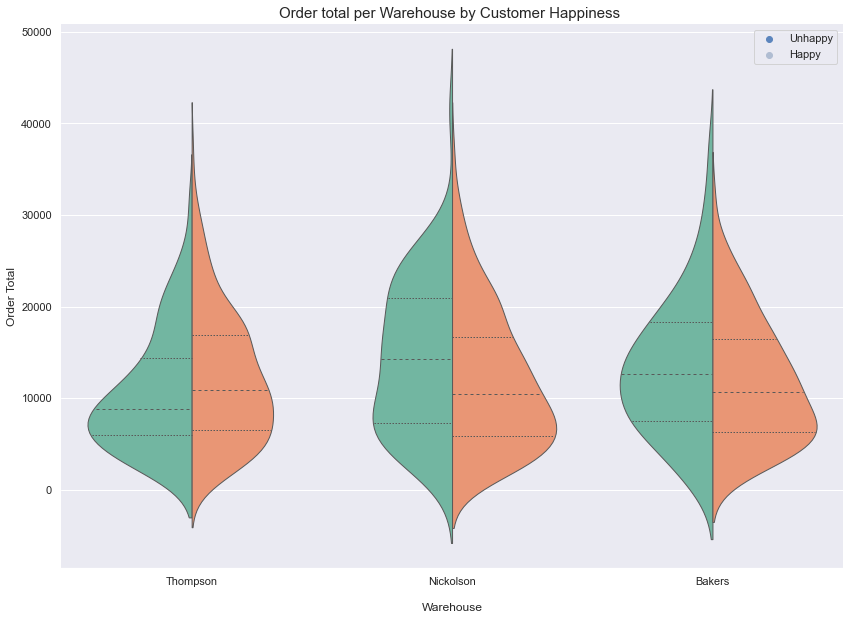

In [771]:
#  total order price by happiness
sns.set_theme(style='darkgrid',palette='Set2')
plt.figure(figsize = (14, 10))

# Draw a sub violinplot and split for easier comparison
cp = sns.violinplot(data=df_order_data_full, x='nearest_warehouse', y='order_total', hue='is_happy_customer',split=True, inner='quart', linewidth=1)
cp.set_title('Order total per Warehouse by Customer Happiness ', fontsize=15);
cp.set_xlabel('\nWarehouse')
cp.set_ylabel('Order Total')
cp.legend(handles=ax.legend_.legendHandles, labels=['Unhappy', 'Happy'])
sns.despine(left=True)
# plt.savefig('Plot_Images/1_Total_Order_Price_by_Happiness.jpg')
plt.show();

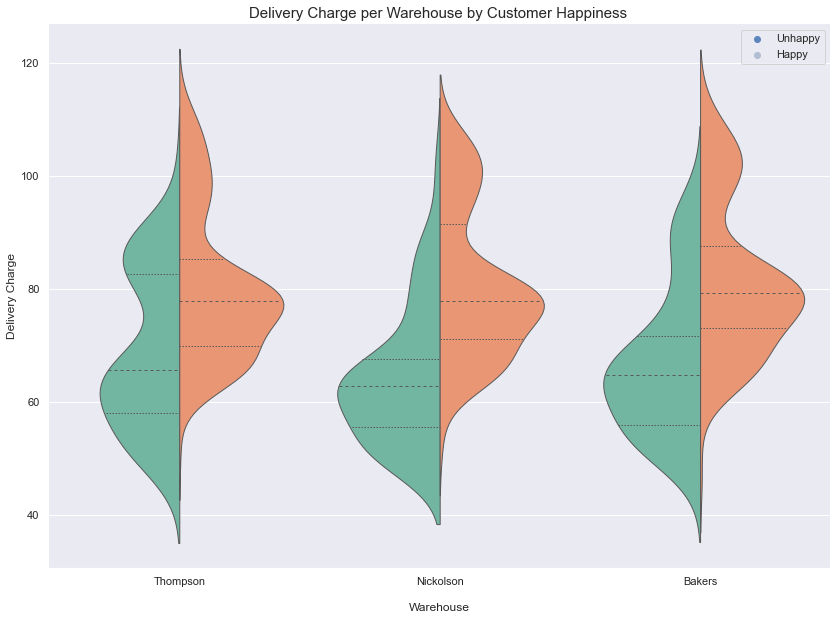

In [772]:
#  Delivery Charge by Happiness

sns.set_theme(style='darkgrid',palette='Set2')
plt.figure(figsize = (14, 10))

# Draw a sub violinplot and split for easier comparison
cp = sns.violinplot(data=df_order_data_full, x='nearest_warehouse', y='delivery_charges', hue='is_happy_customer',split=True, inner='quart', linewidth=1)
cp.set_title('Delivery Charge per Warehouse by Customer Happiness ', fontsize=15);
cp.set_xlabel('\nWarehouse')
cp.set_ylabel('Delivery Charge')
cp.legend(handles=ax.legend_.legendHandles, labels=['Unhappy', 'Happy'])
sns.despine(left=True)
# plt.savefig('Plot_Images/2_Delivery_Charge_by_Happiness.jpg')
plt.show();

In [773]:
# calculate the order discount and add new column to df_order_data_full
df_order_data_full['order_discount'] = (df_order_data_full['order_price'] / 100) * df_order_data_full['coupon_discount']

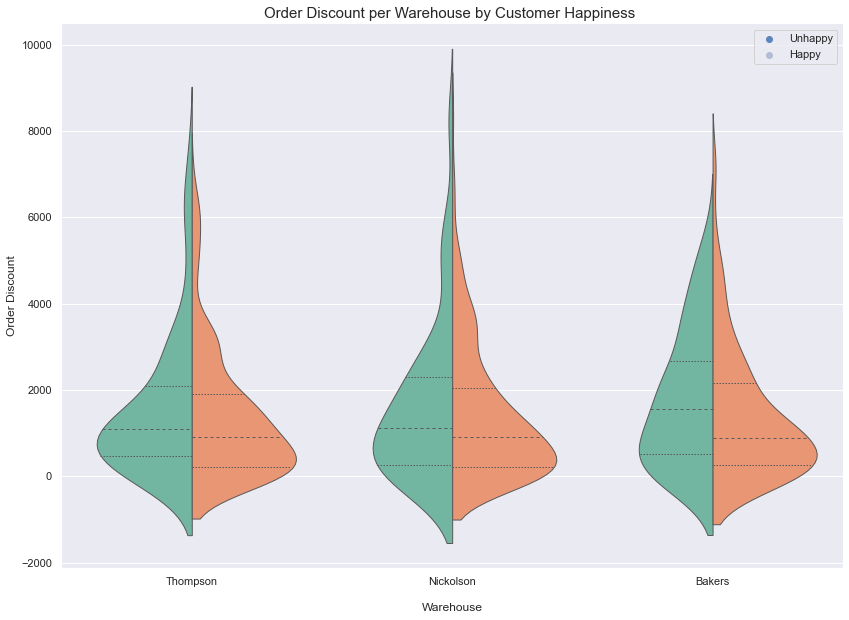

In [774]:
# Order Discount by Happiness

sns.set_theme(style='darkgrid',palette='Set2')
plt.figure(figsize = (14, 10))

# Draw a sub violinplot and split for easier comparison
cp = sns.violinplot(data=df_order_data_full, x='nearest_warehouse', y='order_discount', hue='is_happy_customer',split=True, inner='quart', linewidth=1)
cp.set_title('Order Discount per Warehouse by Customer Happiness ', fontsize=15);
cp.set_xlabel('\nWarehouse')
cp.set_ylabel('Order Discount')
cp.legend(handles=ax.legend_.legendHandles, labels=['Unhappy', 'Happy'])
sns.despine(left=True)
# plt.savefig('Plot_Images/3_Order_Discount_by_Happiness.jpg')
plt.show();

In [775]:
# some order discounts seem high , checking if calculations are correct , all ok
df_order_data_full[df_order_data_full['order_discount'] > 5000].sort_values(by='order_discount', ascending=False).head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,...,postcode_cust,state_cust,country_cust,road_warehouse,suburb_warehouse,city_warehouse,postcode_warehouse,state_warehouse,country_warehouse,order_discount
123,ORD473288,ID0131247270,2019-07-11,Nickolson,"[('Alcon 10', 2), ('iAssist Line', 2), ('Toshika 750', 2), ('Olivia x460', 2)]",33440.0,62.73,-37.812975,144.961922,25,...,3000,Victoria,Australia,Princes Walk,Melbourne,Melbourne,3000,Victoria,Australia,8360.00
881,ORD486999,ID0650268095,2019-03-08,Nickolson,"[('Alcon 10', 2), ('Toshika 750', 2), ('iAssist Line', 2), ('Olivia x460', 2)]",33440.0,79.04,-37.815067,144.974785,25,...,3002,Victoria,Australia,Princes Walk,Melbourne,Melbourne,3000,Victoria,Australia,8360.00
410,ORD198111,ID3293340280,2019-02-19,Nickolson,"[('Universe Note', 2), ('pearTV', 1), ('Lucent 330S', 1), ('Alcon 10', 2)]",32340.0,97.30,-37.823877,144.981668,25,...,3000,Victoria,Australia,Princes Walk,Melbourne,Melbourne,3000,Victoria,Australia,8085.00
329,ORD352051,ID0387152924,2019-03-14,Thompson,"[('Alcon 10', 1), ('Universe Note', 2), ('pearTV', 2), ('Thunder line', 1)]",30650.0,63.01,-37.806140,144.944916,25,...,3003,Victoria,Australia,Dudley Street,Docklands,Melbourne,3008,Victoria,Australia,7662.50
297,ORD320916,ID0702456085,2019-02-26,Bakers,"[('Alcon 10', 2), ('Candle Inferno', 1), ('Toshika 750', 2), ('iAssist Line', 1)]",29195.0,73.43,-37.804908,144.946826,25,...,3003,Victoria,Australia,Victoria Street,Abbotsford,Melbourne,3067,Victoria,Australia,7298.75


In [776]:
# some order discounts seem high , checking if calculations are correct , all ok
df_order_data_full[['order_price','coupon_discount']].sort_values(by=['order_price','coupon_discount'],ascending = False)

,order_price,coupon_discount
51,43520.0,5
358,37570.0,0
649,37300.0,0
56,37150.0,0
71,35205.0,10
...,...,...
810,1010.0,10
182,1010.0,0
277,730.0,10
804,730.0,0


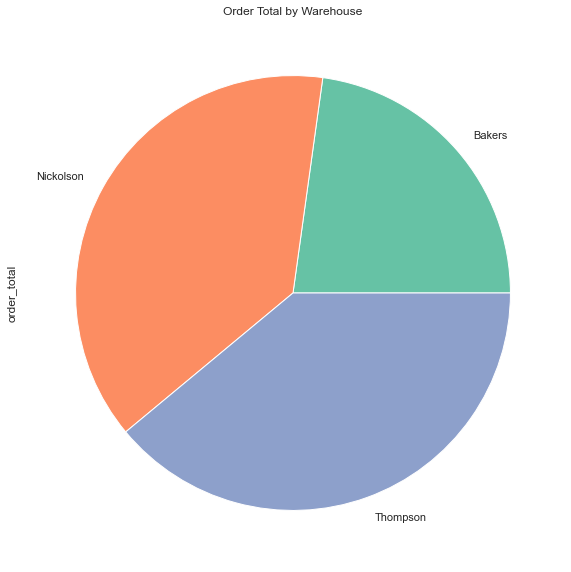

In [778]:
# Order Totals by Warehouse
season_order_tot = df_order_data_full.groupby(['nearest_warehouse'])['order_total'].sum()

sns.set_theme(style='darkgrid',palette='Set2')
plt.figure(figsize = (14, 10))

season_order_tot.plot(kind = 'pie', title='Order Total by Warehouse')

fontdict = { 'fontsize': 30}
# plt.savefig('Plot_Images/4_Order_Total_by_Warehouse.jpg')
plt.show();

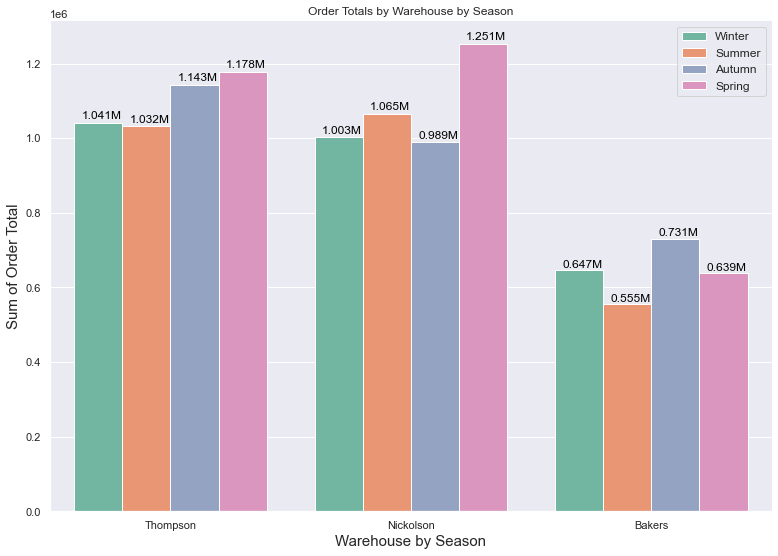

In [779]:
# Total order value by Season grouped by Warehouse
sns.set_theme(style='darkgrid',palette='Set2')

cp = sns.catplot(x='nearest_warehouse', y='order_total', estimator=sum, data=df_order_data_full, kind='bar', hue='season',ci=None, legend=False)
cp.fig.set_size_inches(14, 10)
cp.fig.subplots_adjust(top=0.81,right=0.86) 
cp.set_ylabels('Sum of Order Total', fontsize=15)
cp.set_xlabels('Warehouse by Season', fontsize=15)
cp.set(title='Order Totals by Warehouse by Season')
cp.ax.legend(loc=1,fontsize=12)

ax = cp.facet_axis(0,0)
for pos in ax.patches:
    ax.text(pos.get_x() + .03, 
            pos.get_height() * 1.01, 
           '{0:.003f}M'.format(pos.get_height()/1000000),
            color='black', 
            rotation='horizontal', 
            size='medium')
# plt.savefig('Plot_Images/5_Total_Order_Value_by_Season_Grouped_by_Warehouse.jpg')
plt.show();

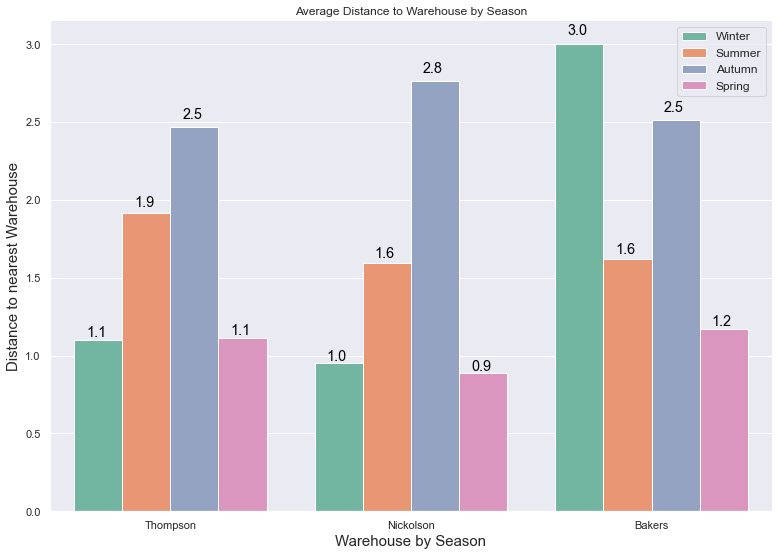

In [780]:
# average distance to nearest Warehouse
sns.set_theme(style='darkgrid', palette='Set2')

cp = sns.catplot(x='nearest_warehouse', y='distance_to_nearest_warehouse', data=df_order_data_full, kind='bar', hue='season',ci=None, legend=False)
cp.fig.set_size_inches(14,10)
cp.fig.subplots_adjust(top=0.81,right=0.86) 
cp.set_ylabels('Distance to nearest Warehouse', fontsize=15)
cp.set_xlabels('Warehouse by Season', fontsize=15)
cp.set(title='Average Distance to Warehouse by Season')
cp.ax.legend(loc=1,fontsize=12)

ax = cp.facet_axis(0,0)
for pos in ax.patches:
    ax.text(pos.get_x() + .05, 
            pos.get_height() * 1.02, 
           '{0:.1f}'.format(pos.get_height()),
            color='black', 
            rotation='horizontal', 
            size='large')
# plt.savefig('Plot_Images/6_Average_Distance_to_Warehouse_by_Season.jpg')
plt.show();

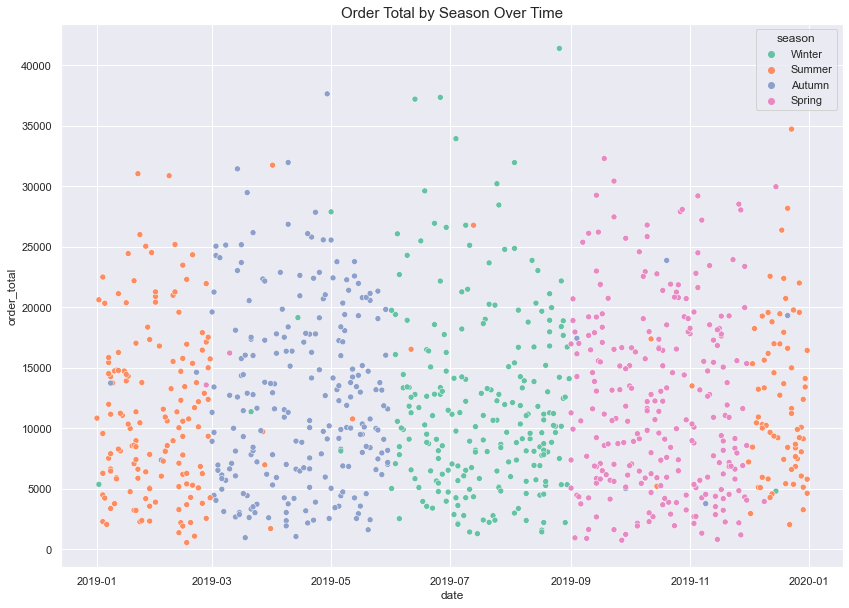

In [781]:
# Order Total by Season Over Time
sns.set_theme(style='darkgrid',palette='Set2')
plt.figure(figsize = (14, 10))
plt.title('Order Total by Season Over Time', fontsize=15)
sns.scatterplot(data=df_order_data_full, x='date', y='order_total', hue='season')
# plt.savefig('Plot_Images/7_Order_Total_by_Season_Over_Time.jpg')
plt.show();

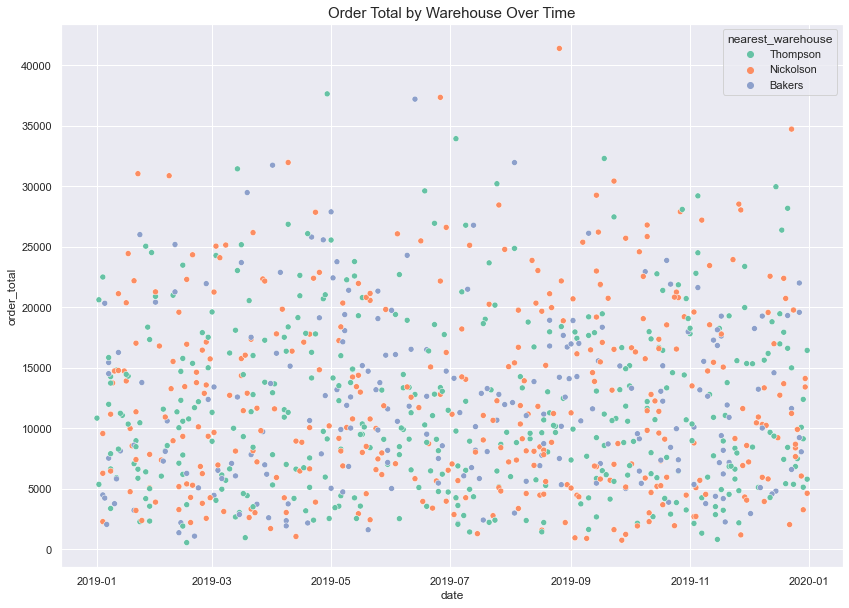

In [782]:
# Order Total by Warehouse Over Time
sns.set_theme(style='darkgrid',palette='Set2')
plt.figure(figsize = (14, 10))
plt.title('Order Total by Warehouse Over Time', fontsize=15)
sns.scatterplot(data=df_order_data_full, x='date', y='order_total', hue='nearest_warehouse')
# plt.savefig('Plot_Images/8_Order_Total_by_Warehouse_Over_Time.jpg')
plt.show();

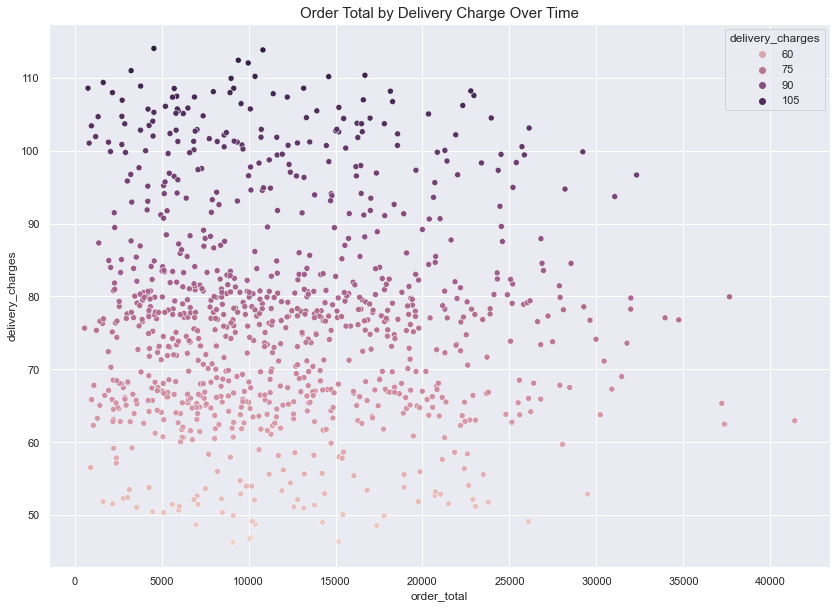

In [783]:
# Order Total by delivery charge Over Time'
plt.figure(figsize = (14, 10))
sns.set_theme(palette='Set2', style='darkgrid')
plt.title('Order Total by Delivery Charge Over Time', fontsize=15)
sns.scatterplot(data=df_order_data_full, x='order_total', y='delivery_charges', hue='delivery_charges')
# plt.savefig('Plot_Images/9_Order_Total_by_Delivery_Charge_Over_Time.jpg')
plt.show();

<Figure size 1008x576 with 0 Axes>

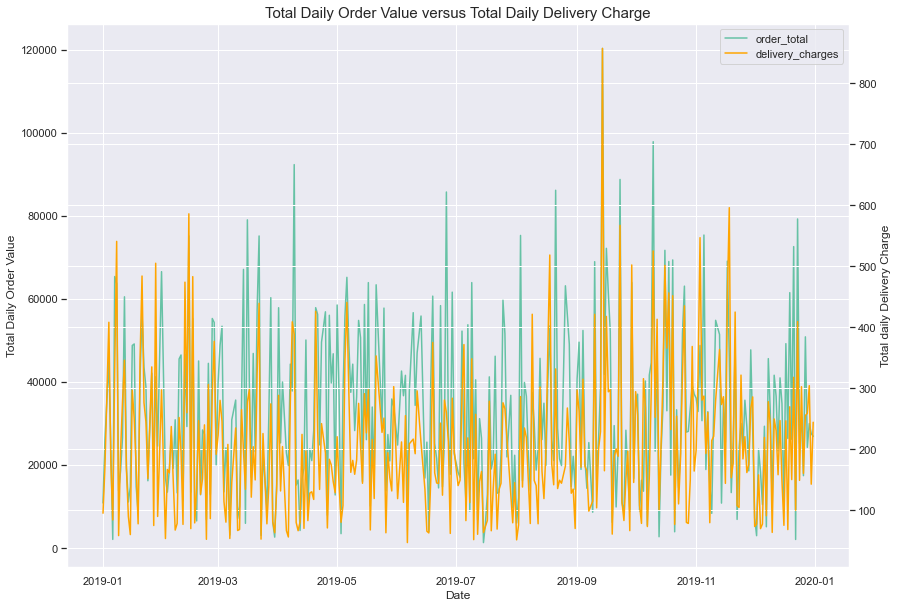

In [784]:
# Total Daily Order Value versus Total Daily Delivery Charge
sns.set_theme(style='darkgrid',palette='Set2')

x =  df_order_data_full['date'].sort_values().unique()
data_1 = df_order_data_full.groupby(['date'])['order_total'].sum()
data_2 = df_order_data_full.groupby(['date'])['delivery_charges'].sum()

plt.figure(figsize=(14,8));

fig, ax1 = plt.subplots(figsize=(14,10))

ax1.set_xlabel('Date') 
ax1.set_ylabel('Total Daily Order Value') 
plot_1 = ax1.plot(x, data_1, label='order_total') 
ax1.tick_params(axis ='y');

ax2 = ax1.twinx() 
ax2.set_ylabel('Total daily Delivery Charge') 
plot_2 = ax2.plot(x, data_2,color='orange' ,label = 'delivery_charges') 
ax2.tick_params(axis ='y')

lns = plot_1 + plot_2 
labels = [l.get_label() for l in lns]
plt.title('Total Daily Order Value versus Total Daily Delivery Charge',fontsize=15)
plt.legend(lns, labels, loc=0)
plt.savefig('Plot_Images/10_Total_Daily_Order_Value_versus_Total_Daily_Delivery_Charge.jpg')
plt.show();